# import

In [19]:
import pandas as pd
import numpy as np
import os
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
import time
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping, Callback, ModelCheckpoint
from tensorflow.keras.activations import relu, softmax
from tensorflow.keras import metrics
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

In [20]:
# 시각화 선명도
%config InlineBackend.figure_format = 'retina' 
# 한글설정 축의 깨짐 방지
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)
# warining 경고 안보이게
warnings.filterwarnings(action='ignore')
# warining 경고 보이게
# warnings.filterwarnings(action='default')

# .csv concat

In [23]:
folder = 'data' # csv있는 폴더
csv_files = [file for file in os.listdir(folder) if file.endswith('.csv')]
dataframes = [pd.read_csv(os.path.join(folder, file)) for file in csv_files]
movie_df = pd.concat(dataframes, ignore_index=True)
movie_df.to_csv('result/movie_df.csv', index=False, encoding='utf-8')
print(len(movie_df)) # 총 6043
movie = movie_df.copy()

6043


# 영화 장르 결측치 웹크롤링

In [25]:
def genre_nm_none_list(df):
    title_list=[]
    title_list.append(df.loc[df['GENRE_NM'].isna(), 'MOVIE_NM'].values)
    return title_list

In [26]:
result_list = genre_nm_none_list(movie)
movie_title = result_list[0].tolist()
genre_lists = set(movie['GENRE_NM'])

In [27]:
# 동적 웹 크롤링으로 장르 받아오기 (naver)
def naver_crawling_genre(genre_non_list):
    dv = webdriver.Chrome()
    dv.get('http://www.naver.com')
    time.sleep(1.5)
    el = dv.find_element(By.CSS_SELECTOR, 'input#query')
    for title in genre_non_list :
        el.clear()
        el.send_keys('영화 {} 정보'.format(title))
        el.send_keys(Keys.ENTER)
        time.sleep(1.5)
        genres = dv.find_elements(By.CSS_SELECTOR, 'div.info_group dd')[2]
        el = dv.find_element(By.CSS_SELECTOR, 'input#nx_query')
        genre = genres.text.split(', ')[0]
        flag = True
        for word in list(genre_lists):
            if word==genre:
                flag = False
                break;
        if(flag):
            genre = np.nan
        movie.loc[movie['MOVIE_NM']==title, 'GENRE_NM'] = genre
        el.clear()
    dv.close()

In [28]:
naver_crawling_genre(movie_title)
movie.to_csv('result/movie.csv', index=False, encoding='utf-8')
movie = pd.read_csv('result/movie.csv')
movie.head()

<bound method NDFrame.head of        NO                     MOVIE_NM    DRCTR_NM                   MAKR_NM  \
0       1                           소울       피트 닥터  월트 디즈니 픽쳐스,픽사 애니메이션 스튜디오   
1       2            극장판 귀멸의 칼날: 무한열차편    소토자키 하루오                       NaN   
2       3                   원더 우먼 1984      팻티 젠킨스                       NaN   
3       4                          세자매         이승원                  (주)영화사 업   
4       5             명탐정 코난: 진홍의 수학여행  야마모토 야스이치로                       NaN   
...   ...                          ...         ...                       ...   
6038   96         뉴클래식 프로젝트 미안하다, 사랑한다         NaN                 콘텐츠웨이브(주)   
6039   97           극장판 블루 록 -에피소드 나기-    이시카와 슌스케                       NaN   
6040   98  우리는 천국에 갈 순 없지만 사랑은 할 수 있겠지         한제이               (주)에스더블유콘텐츠   
6041   99                       딸에 대하여         이미랑                     (주)아토   
6042  100                      퍼펙트 데이즈       빔 벤더스                       NaN   

         

# 영화 평점 추가 & 평점 웹크롤링

In [8]:
# 평점 컬럼명 추가
movie['네이버_평점'] = np.nan
movie['씨네21_평점'] = np.nan
movie.to_csv('result/movie.csv', index=False, encoding='utf-8')
movie.head()

,NO,MOVIE_NM,DRCTR_NM,MAKR_NM,INCME_CMPNY_NM,DISTB_CMPNY_NM,OPN_DE,MOVIE_TY_NM,MOVIE_STLE_NM,NLTY_NM,TOT_SCRN_CO,SALES_PRICE,VIEWNG_NMPR_CO,SEOUL_SALES_PRICE,SEOUL_VIEWNG_NMPR_CO,GENRE_NM,GRAD_NM,MOVIE_SDIV_NM,네이버_평점,씨네21_평점
0,1,소울,피트 닥터,"월트 디즈니 픽쳐스,픽사 애니메이션 스튜디오",월트디즈니컴퍼니코리아 유한책임회사,월트디즈니컴퍼니코리아 유한책임회사,20210120,개봉영화,장편,미국,2018,7936332910,875001,2578880980,275009,애니메이션,전체관람가,일반영화,NaN,NaN
1,2,극장판 귀멸의 칼날: 무한열차편,소토자키 하루오,NaN,에스엠지홀딩스 주식회사,워터홀컴퍼니(주),20210127,개봉영화,장편,일본,380,1820102670,206309,507360670,54677,애니메이션,15세이상관람가,일반영화,NaN,NaN
2,3,원더 우먼 1984,팻티 젠킨스,NaN,워너브러더스 코리아(주),워너브러더스 코리아(주),20201223,개봉영화,장편,미국,2260,1445202000,155562,425776520,43999,액션,12세이상관람가,일반영화,NaN,NaN
3,4,세자매,이승원,(주)영화사 업,NaN,(주)리틀빅픽쳐스,20210127,개봉영화,장편,한국,569,354451240,42290,110117100,12825,드라마,15세이상관람가,독립/예술영화,NaN,NaN
4,5,명탐정 코난: 진홍의 수학여행,야마모토 야스이치로,NaN,(주)씨제이이엔엠,(주)씨제이이엔엠,20210127,개봉영화,장편,일본,532,316132440,38131,61262750,7166,애니메이션,12세이상관람가,일반영화,NaN,NaN


In [9]:
movie_title = set(movie['MOVIE_NM'])
len(movie_title) # 2579

2579

In [27]:
# 동적 웹 크롤링으로 평점 받아오기 (naver)
def naver_crawling_grade(grade_non_list):
    grade_list = []
    dv = webdriver.Chrome()
    dv.get('http://www.naver.com')
    time.sleep(1.5)
    el = dv.find_element(By.CSS_SELECTOR, 'input#query')
    
    for title in grade_non_list :
        el.clear()
        el.send_keys('영화 {} 평점'.format(title))
        el.send_keys(Keys.ENTER)
        time.sleep(1.5)
        
        try :
            grades = dv.find_element(By.CSS_SELECTOR, 'span.area_star_number')
            grade = grades.text
            grade = round(float(grade), 2)
        except :
            grade = np.nan
            
        movie.loc[movie['MOVIE_NM']==title, '네이버_평점'] = grade
        
        el = dv.find_element(By.CSS_SELECTOR, 'input#nx_query')
    
    dv.close()
    movie.to_csv('result/movie.csv', index=False, encoding='utf-8')

In [28]:
naver_crawling_grade(movie_title)

다음 평점 업데이트 완료! result/movie.csv에 저장되었습니다.
       NO          MOVIE_NM   DRCTR_NM      MAKR_NM INCME_CMPNY_NM  \
0       1           남산의 부장들        우민호  (주)하이브미디어코프            NaN   
1       2       다만 악에서 구하소서        홍원찬  (주)하이브미디어코프            NaN   
2       3                반도        연상호   (주)영화사레드피터            NaN   
3       4               히트맨        최원섭   베리굿스튜디오(주)            NaN   
4       5                테넷   크리스토퍼 놀란          NaN  워너브러더스 코리아(주)   
...   ...               ...        ...          ...            ...   
5986  115    아녜스 V에 의한 제인 B    아녜스 바르다          NaN    (주)영화사 안다미로   
5987  116        사랑은 낙엽을 타고  아키 카우리스마키          NaN             찬란   
5988  117              베어헌터      안톤 머스          NaN    주식회사 원더스튜디오   
5989  118  뽀로로 극장판 슈퍼스타 대모험    윤제완,김성민        (주)오콘            NaN   
5990  120      소녀는 졸업하지 않는다     나카가와 슌          NaN            해피송   

           DISTB_CMPNY_NM    OPN_DE MOVIE_TY_NM MOVIE_STLE_NM NLTY_NM  ...  \
0                  (주)쇼박스  20200122    

In [ ]:
# 동적 웹 크롤링으로 평점 받아오기 (cene21)
def cene21_crawling_grade(grade_non_list, file_path):
    dv = webdriver.Chrome()
    dv.get('http://www.cine21.com/')
    time.sleep(1.5)
    el = dv.find_element(By.CSS_SELECTOR, 'input.input_search')
    
    try:
        movie = pd.read_csv(file_path)
    except :
        movie = pd.DataFrame({'MOVIE_NM': movie_title})
        
    for title in grade_non_list :
        el.clear()
        el.send_keys('{}'.format(title))
        el.send_keys(Keys.ENTER)
        time.sleep(1.5)
        
        try :
            grades = dv.find_element(By.CSS_SELECTOR, 'span.num')
            grade = grades.text
            grade = round(float(grade), 2)
            
        except :
            grade = np.nan
            
        movie.loc[movie['MOVIE_NM']==title, '씨네21_평점'] = grade
        
        el = dv.find_element(By.CSS_SELECTOR, 'input.input_search')
    
    dv.close()
    movie.to_csv('result/movie_cine21.csv', index=False, encoding='utf-8')

In [19]:
cene21_crawling_grade(movie_title, file_path)

NameError: name 'cene21_crawling_grade' is not defined

In [29]:
movie_naver = pd.read_csv('result/movie_naver.csv')
movie_cine21 = pd.read_csv('result/movie_cine21.csv')
movie['네이버_평점'] = movie_naver['네이버_평점']
movie['씨네21_평점'] = movie_cine21['씨네21_평점']
movie.sample(5)

,NO,MOVIE_NM,DRCTR_NM,MAKR_NM,INCME_CMPNY_NM,DISTB_CMPNY_NM,OPN_DE,MOVIE_TY_NM,MOVIE_STLE_NM,NLTY_NM,TOT_SCRN_CO,SALES_PRICE,VIEWNG_NMPR_CO,SEOUL_SALES_PRICE,SEOUL_VIEWNG_NMPR_CO,GENRE_NM,GRAD_NM,MOVIE_SDIV_NM,네이버_평점,씨네21_평점
5035,31,길위에 김대중,민환기,"(주)명필름,(주)시네마6411",NaN,"(주)아이오케이컴퍼니,(주)명필름,(주)시네마6411",20240110,개봉영화,장편,한국,414,100845417,11356,39504830,4358,다큐멘터리,12세이상관람가,독립/예술영화,9.64,6.00
2509,89,#해시태그,이상식,(주)더존크리에이티브,NaN,(주)더존크리에이티브,2022-06-,개봉영화,장편,한국,8.0,NaN,173.0,NaN,118.0,공연,12세이상관람가,일반영화,NaN,7.00
3657,45,"오늘 밤, 세계에서 이 사랑이 사라진다 해도",미키 타카히로,NaN,(주)미디어캐슬,"(주)바이포엠스튜디오,홀리가든",20221130,개봉영화,장편,일본,258.0,NaN,NaN,NaN,NaN,멜로/로맨스,12세이상관람가,독립/예술영화,7.94,5.33
2247,110,도진강호,NaN,NaN,NaN,초코필름,2022-04-,개봉영화,장편,중국,5.0,NaN,100.0,NaN,20.0,액션,15세이상관람가,독립/예술영화,0.00,NaN
5359,17,극장판 실바니안 패밀리: 프레야의 선물,코나카 카즈야,NaN,미라지엔터테인먼트,(주)라이크콘텐츠,20240501,개봉영화,장편,일본,197,"165,864,210","20,711","46,637,990","5,714",애니메이션,전체관람가,일반영화,6.62,5.50


# columns 정리 & columns명 변경

In [31]:
movies = movie.drop(columns={'NO','DRCTR_NM','MAKR_NM','INCME_CMPNY_NM','MOVIE_TY_NM','MOVIE_STLE_NM','NLTY_NM','SALES_PRICE',
                    'SEOUL_SALES_PRICE','SEOUL_VIEWNG_NMPR_CO' ,'MOVIE_SDIV_NM'})
movies = movies.rename(columns={'MOVIE_NM':'영화제목', 'DISTB_CMPNY_NM':'유통회사명', 'OPN_DE':'개봉일', 
                                'TOT_SCRN_CO':'총스크린수', 'VIEWNG_NMPR_CO':'관람객수', 
                                'GENRE_NM':'장르', 'GRAD_NM':'등급', '네이버_평점':'네이버_평점', 
                                '씨네21_평점':'씨네21_평점'})
# movies

,영화제목,유통회사명,개봉일,총스크린수,관람객수,장르,등급,네이버_평점,씨네21_평점
0,소울,월트디즈니컴퍼니코리아 유한책임회사,20210120,2018,875001,애니메이션,전체관람가,9.32,8.50
1,극장판 귀멸의 칼날: 무한열차편,워터홀컴퍼니(주),20210127,380,206309,애니메이션,15세이상관람가,NaN,6.00
2,원더 우먼 1984,워너브러더스 코리아(주),20201223,2260,155562,액션,12세이상관람가,7.54,5.50
3,세자매,(주)리틀빅픽쳐스,20210127,569,42290,드라마,15세이상관람가,8.95,5.00
4,명탐정 코난: 진홍의 수학여행,(주)씨제이이엔엠,20210127,532,38131,애니메이션,12세이상관람가,8.02,5.00
...,...,...,...,...,...,...,...,...,...
6038,"뉴클래식 프로젝트 미안하다, 사랑한다",씨제이 씨지브이(CJ CGV)(주),20241116,7,676,멜로/로맨스,15세이상관람가,8.33,NaN
6039,극장판 블루 록 -에피소드 나기-,씨제이 씨지브이(CJ CGV)(주),20240821,276,674,애니메이션,12세이상관람가,10.00,NaN
6040,우리는 천국에 갈 순 없지만 사랑은 할 수 있겠지,(주)메리크리스마스,20241016,87,652,드라마,15세이상관람가,8.06,6.00
6041,딸에 대하여,"찬란,스튜디오 에이드",20240904,106,609,드라마,12세이상관람가,7.06,7.00


# 결측치처리

In [350]:
# type확인
movies.info()
# 컬럼별 결측치 수 확인
movies_cnt = movies.isna().sum()
movies_cnt

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6041 entries, 0 to 6040
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   영화제목     6041 non-null   object 
 1   유통회사명    6041 non-null   object 
 2   개봉년도     6041 non-null   int64  
 3   개봉월      6041 non-null   int64  
 4   총스크린수    6041 non-null   float64
 5   관람객수     4186 non-null   float64
 6   장르       6041 non-null   object 
 7   등급       6041 non-null   object 
 8   네이버_평점   5478 non-null   float64
 9   씨네21_평점  4731 non-null   float64
dtypes: float64(4), int64(2), object(4)
memory usage: 472.1+ KB


영화제목          0
유통회사명         0
개봉년도          0
개봉월           0
총스크린수         0
관람객수       1855
장르            0
등급            0
네이버_평점      563
씨네21_평점    1310
dtype: int64

In [352]:
# 결측치 처리 ['개봉월'] 2개 삭제
movies = movies.dropna(subset=['개봉월'])
# movies.head()

,영화제목,유통회사명,개봉년도,개봉월,총스크린수,관람객수,장르,등급,네이버_평점,씨네21_평점
0,소울,월트디즈니컴퍼니코리아 유한책임회사,2021,1,2018.0,875001.0,애니메이션,전체관람가,9.32,8.5
1,극장판 귀멸의 칼날: 무한열차편,워터홀컴퍼니(주),2021,1,380.0,206309.0,애니메이션,15세이상관람가,NaN,6.0
2,원더 우먼 1984,워너브러더스 코리아(주),2020,12,2260.0,155562.0,액션,12세이상관람가,7.54,5.5
3,세자매,(주)리틀빅픽쳐스,2021,1,569.0,42290.0,드라마,15세이상관람가,8.95,5.0
4,명탐정 코난: 진홍의 수학여행,(주)씨제이이엔엠,2021,1,532.0,38131.0,애니메이션,12세이상관람가,8.02,5.0


In [34]:
# 개봉일 datetype으로 변환
movies['개봉년도'] = movies['개봉일'].str[:4]
movies['개봉월'] = movies['개봉일'].str.replace('-','').str[4:6]
# print(movies['개봉년도']), print(movies['개봉월'])

0       2021
1       2021
2       2020
3       2021
4       2021
        ... 
6038    2024
6039    2024
6040    2024
6041    2024
6042    2024
Name: 개봉년도, Length: 6041, dtype: object
0       01
1       01
2       12
3       01
4       01
        ..
6038    11
6039    08
6040    10
6041    09
6042    07
Name: 개봉월, Length: 6041, dtype: object


(None, None)

In [35]:
# 개봉년도  개봉월 분리 후 개봉일 삭제 후 컬럼순서 변경
movies = movies.drop(columns='개봉일')
movies = movies[['영화제목','유통회사명','개봉년도','개봉월','총스크린수','관람객수','장르','등급','네이버_평점','씨네21_평점']]
# movies.head()

,영화제목,유통회사명,개봉년도,개봉월,총스크린수,관람객수,장르,등급,네이버_평점,씨네21_평점
0,소울,월트디즈니컴퍼니코리아 유한책임회사,2021,01,2018,875001,애니메이션,전체관람가,9.32,8.5
1,극장판 귀멸의 칼날: 무한열차편,워터홀컴퍼니(주),2021,01,380,206309,애니메이션,15세이상관람가,NaN,6.0
2,원더 우먼 1984,워너브러더스 코리아(주),2020,12,2260,155562,액션,12세이상관람가,7.54,5.5
3,세자매,(주)리틀빅픽쳐스,2021,01,569,42290,드라마,15세이상관람가,8.95,5.0
4,명탐정 코난: 진홍의 수학여행,(주)씨제이이엔엠,2021,01,532,38131,애니메이션,12세이상관람가,8.02,5.0


In [36]:
# 결측치 처리 ['장르'] 2개 기타로 
movies[movies['장르'].isnull()]
movies['장르'] = movies['장르'].fillna('기타')
movies[movies['장르']=='기타']

,영화제목,유통회사명,개봉년도,개봉월,총스크린수,관람객수,장르,등급,네이버_평점,씨네21_평점
88,마지막 휴가,(주)드림팩트엔터테인먼트,2020,12,11,89,기타,15세이상관람가,9.17,3.00
169,"구라, 베토벤",목영이엔엠,2021,02,11,2602,기타,15세이상관람가,NaN,5.00
332,"구라, 베토벤",목영이엔엠,2021,02,11,992,기타,15세이상관람가,NaN,5.00
468,잃어버린 아이들,(주)영화사오원,2021,04,26,678,기타,12세이상관람가,8.65,6.00
496,나의 먼 가족,주식회사 씨엠닉스,2021,04,1,121,기타,12세이상관람가,0.00,NaN
...,...,...,...,...,...,...,...,...,...,...
5828,"안전제일, 놀이퀴즈 최강전",(주)니즈텔레콤,2024,04,2,490,기타,전체관람가,0.00,5.00
5830,우당탕탕 운동회,(주)니즈텔레콤,2024,04,1,469,기타,전체관람가,8.30,5.67
5835,쿵쿵따 탐험대,(주)니즈텔레콤,2024,06,2,399,기타,전체관람가,0.00,NaN
6009,애시드 레인: 죽음의 비,(주)디스테이션,2024,11,48,"2,508",기타,15세이상관람가,8.94,7.25


In [37]:
# 결측치 처리 ['총스크린수'] 총스크린수 중위수으로 대체 
movies['총스크린수'] = movies['총스크린수'].str.replace(',','').astype(np.float32)
median_screen_count = movies['총스크린수'].median()
movies['총스크린수'] = movies['총스크린수'].fillna(median_screen_count)
# movies['총스크린수']

0       2018.0
1        380.0
2       2260.0
3        569.0
4        532.0
         ...  
6038       7.0
6039     276.0
6040      87.0
6041     106.0
6042     137.0
Name: 총스크린수, Length: 6041, dtype: float32

In [40]:
# 결측치 처리 ['장르']['개봉월']을 사용하여 ['관람인원수']['네이버_평점']['씨네21_평점']평균으로 대체
movies['관람객수'] = movies['관람객수'].str.replace(',', '').astype(np.float32)
movies_visitors = movies.groupby(['장르', '개봉월'])['관람객수'].mean().unstack()
# movies_visitors
naver_mean = movies.groupby(['장르', '개봉월'])['네이버_평점'].mean().unstack()
# naver_mean
cine_mean = movies.groupby(['장르', '개봉월'])['씨네21_평점'].mean().unstack()
# cine_mean

개봉월,01,02,03,04,05,06,07,08,09,10,11,12
장르,,,,,,,,,,,,
SF,NaN,5.665000,4.000000,5.164000,4.835000,7.052000,3.333333,6.000000,7.025714,6.588571,5.166667,6.166250
가족,5.666667,6.475000,6.150000,6.250000,4.000000,5.000000,NaN,NaN,6.250000,5.165000,6.375000,NaN
공연,6.670000,8.750000,8.446250,6.117500,6.335000,4.951429,7.256667,6.353077,6.375000,6.290000,5.250000,7.083333
공포(호러),5.665556,4.868000,5.449000,5.172857,5.352308,6.696667,5.856207,5.486000,5.564706,4.622381,6.097222,5.910769
기타,4.963333,5.187500,6.000000,6.074444,7.132500,5.317500,6.462727,6.833333,2.000000,5.670000,7.250000,6.200000
다큐멘터리,6.322439,5.979048,6.236207,6.739394,6.202391,6.647077,6.342105,6.085714,6.650789,6.046393,6.160492,5.804524
드라마,6.042624,6.139316,6.230652,6.248609,6.419554,6.318788,6.009012,6.331622,6.327647,6.288468,6.615372,6.492533
멜로/로맨스,6.428571,5.661944,5.728966,5.563750,5.926111,4.611111,6.072941,6.800000,5.677500,5.277778,5.606905,5.821111
뮤지컬,5.000000,4.000000,NaN,NaN,7.248000,6.375000,NaN,NaN,8.400000,NaN,6.112500,NaN


In [41]:
def fillna_mean(row):
    row = row.copy()
    visitors = row['관람객수']
    ngrade = row['네이버_평점']
    cgrade = row['씨네21_평점']
    genre = row['장르']
    month = row['개봉월']
    
    if pd.isna(visitors):
        row['관람객수'] = movies_visitors.loc[genre, month]
    if pd.isna(ngrade):
        row['네이버_평점'] = naver_mean.loc[genre, month]
    if pd.isna(cgrade):
        row['씨네21_평점'] = cine_mean.loc[genre, month]
    return row

In [42]:
# 함수 test
print(fillna_mean(movies.loc[12])) # 관람객수 160 # 네이버 12 # 씨네21 45

영화제목            커넥트
유통회사명      (주)이수C&E
개봉년도           2021
개봉월              01
총스크린수         386.0
관람객수        14140.0
장르           공포(호러)
등급         15세이상관람가
네이버_평점     5.848333
씨네21_평점         5.0
Name: 12, dtype: object


In [55]:
movies_mean = movies.apply(fillna_mean, axis=1)
movies_mean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6041 entries, 0 to 6042
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   영화제목     6041 non-null   object 
 1   유통회사명    6041 non-null   object 
 2   개봉년도     6041 non-null   object 
 3   개봉월      6041 non-null   object 
 4   총스크린수    6041 non-null   float64
 5   관람객수     6040 non-null   float64
 6   장르       6041 non-null   object 
 7   등급       6041 non-null   object 
 8   네이버_평점   6031 non-null   float64
 9   씨네21_평점  6005 non-null   float64
dtypes: float64(4), object(6)
memory usage: 648.2+ KB


In [56]:
# 나머지 결측치 drop
movies_mean.loc[movies_mean['관람객수'].isna()] # 결측치 처리후 결측치 1
movies_mean.loc[movies_mean['네이버_평점'].isna()] # 결측치 처리후 결측치 10
movies_mean.loc[movies_mean['씨네21_평점'].isna()] # 결측치 처리후 결측치 36
movies_mean = movies_mean.dropna(subset=['관람객수', '네이버_평점', '씨네21_평점'])
# movies_mean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5999 entries, 0 to 6042
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   영화제목     5999 non-null   object 
 1   유통회사명    5999 non-null   object 
 2   개봉년도     5999 non-null   object 
 3   개봉월      5999 non-null   object 
 4   총스크린수    5999 non-null   float64
 5   관람객수     5999 non-null   float64
 6   장르       5999 non-null   object 
 7   등급       5999 non-null   object 
 8   네이버_평점   5999 non-null   float64
 9   씨네21_평점  5999 non-null   float64
dtypes: float64(4), object(6)
memory usage: 515.5+ KB


In [355]:
# ['네이버_평점'], ['씨네21_평점'] 평균으로 평점 column만들기
movies_mean['평균평점'] = (movies_mean['네이버_평점']+movies_mean['씨네21_평점']) /2
# movies_mean.head()

,영화제목,유통회사명,개봉년도,개봉월,총스크린수,관람객수,장르,등급,네이버_평점,씨네21_평점,평균평점,장르2,등급_le,관람객수_le,계절_le,계절,관객수_등급,장르_le
0,소울,월트디즈니컴퍼니코리아 유한책임회사,2021,1,2018.0,875001.0,애니메이션,전체관람가,9.320000,8.5,8.910000,0,2,2070,3,4,3,0
1,극장판 귀멸의 칼날: 무한열차편,워터홀컴퍼니(주),2021,1,380.0,206309.0,애니메이션,15세이상관람가,8.392941,6.0,7.196471,0,1,1978,3,4,3,0
2,원더 우먼 1984,워너브러더스 코리아(주),2020,12,2260.0,155562.0,액션,12세이상관람가,7.540000,5.5,6.520000,1,0,1957,3,4,3,1
3,세자매,(주)리틀빅픽쳐스,2021,1,569.0,42290.0,드라마,15세이상관람가,8.950000,5.0,6.975000,2,1,1832,3,4,3,2
4,명탐정 코난: 진홍의 수학여행,(주)씨제이이엔엠,2021,1,532.0,38131.0,애니메이션,12세이상관람가,8.020000,5.0,6.510000,0,0,1811,3,4,3,0


# 그래프

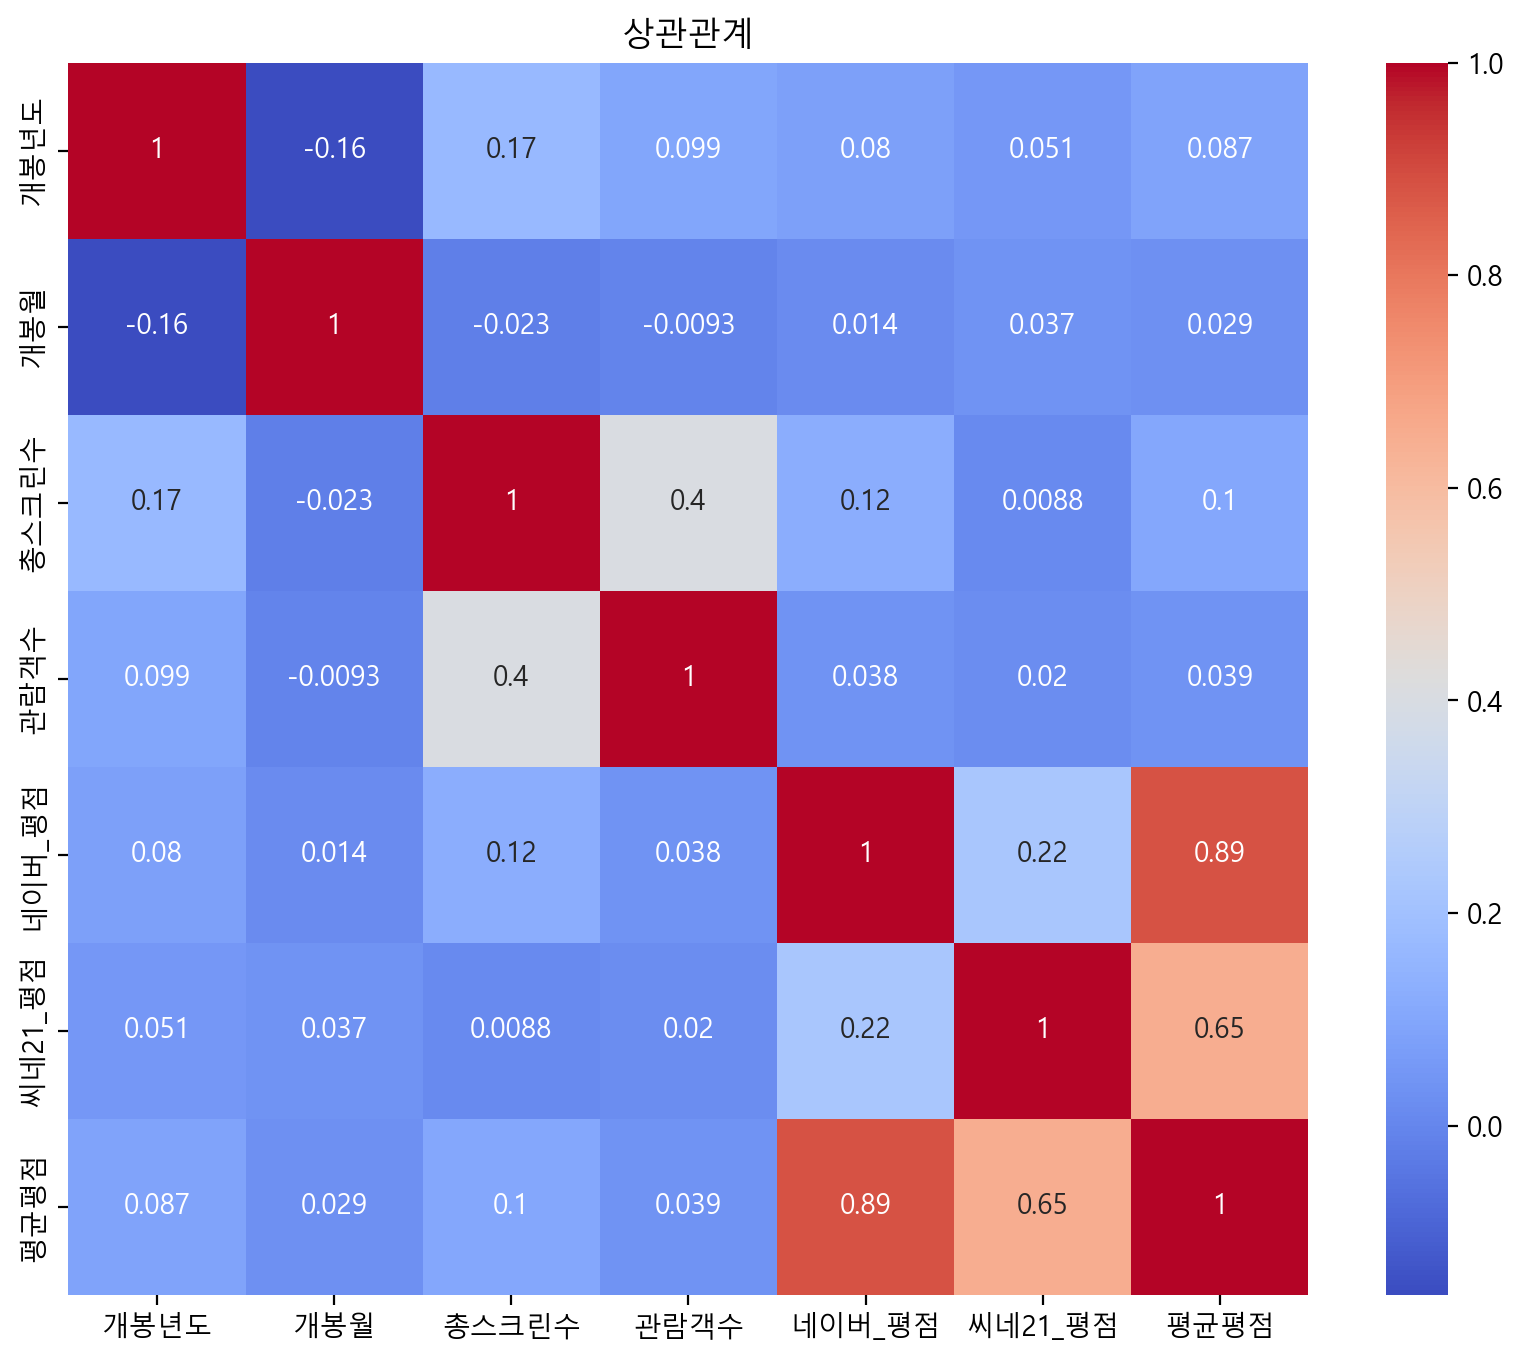

In [364]:
corr = movies_mean.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("상관관계")
plt.show()

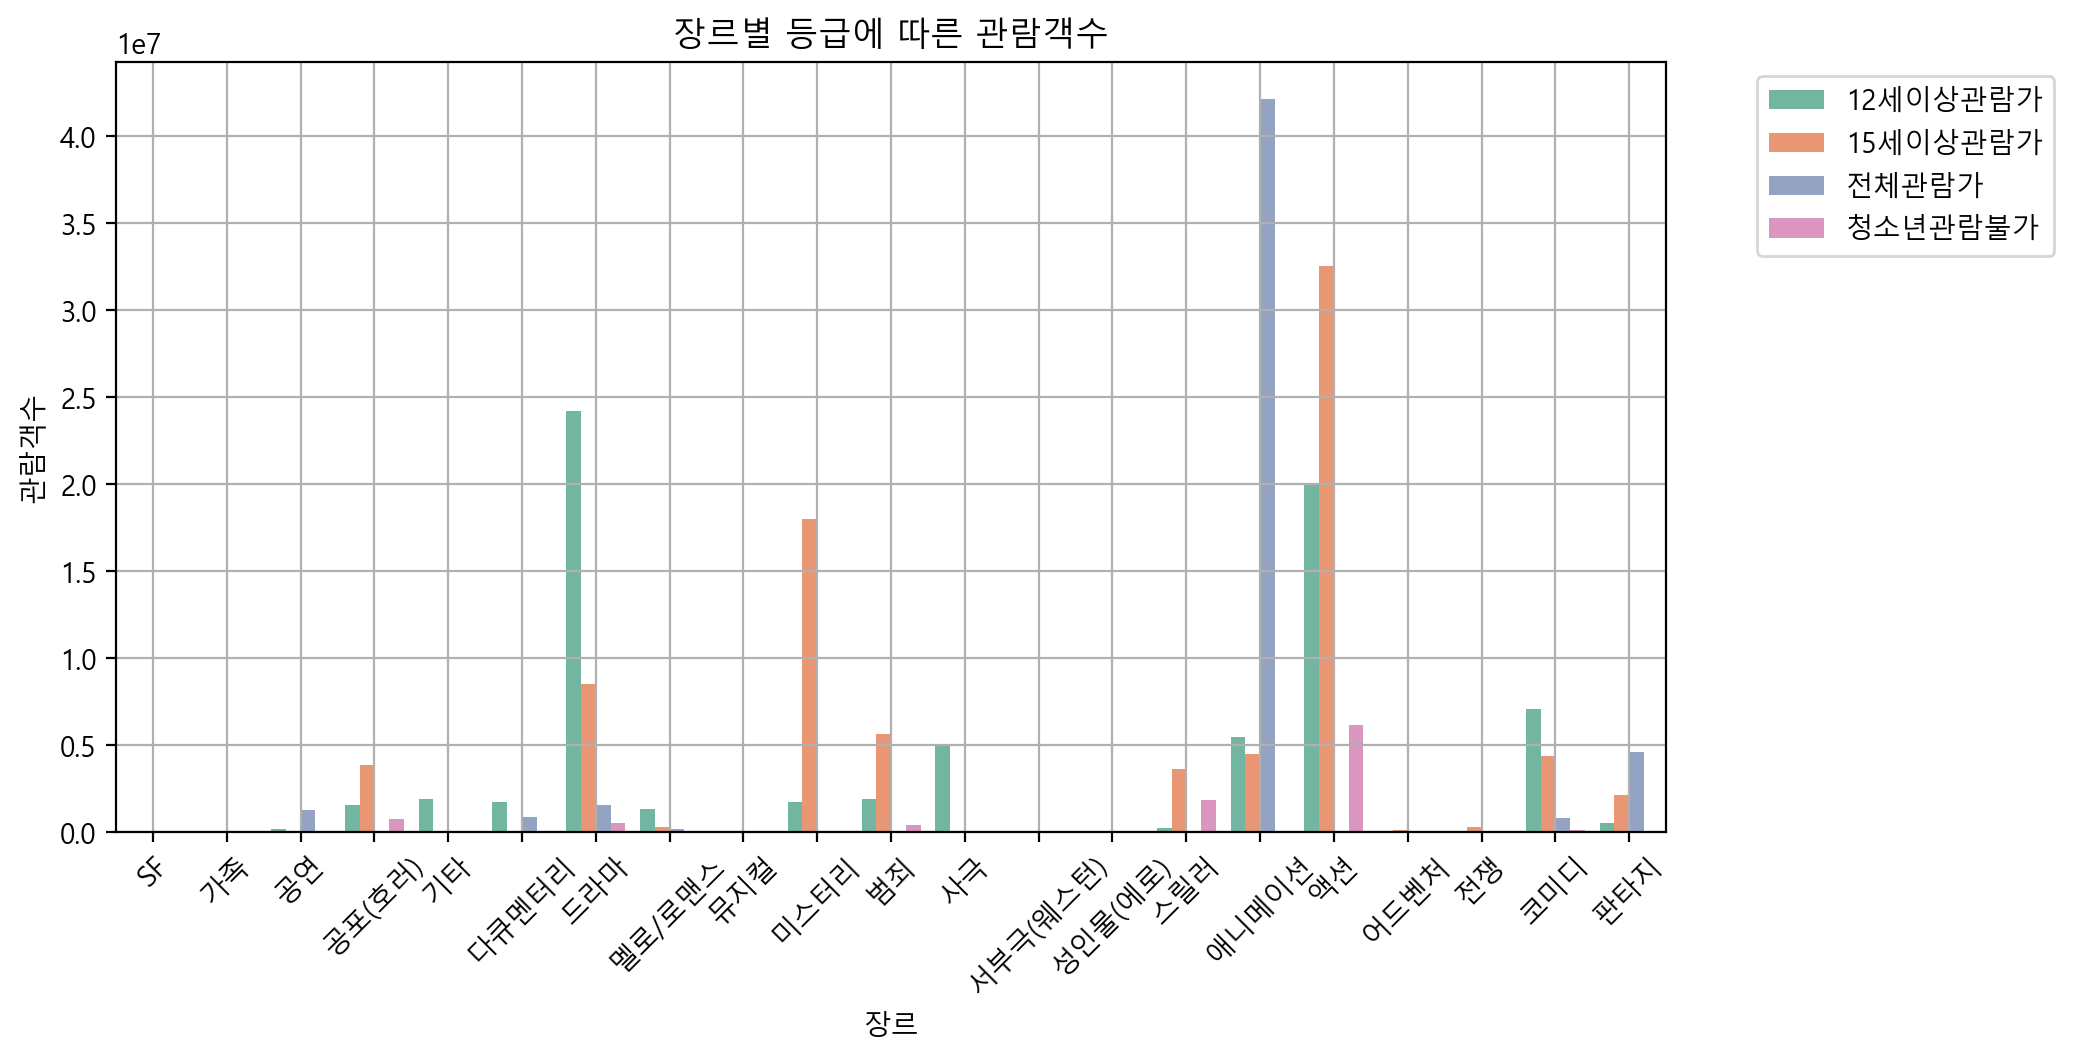

In [60]:
plt.figure(figsize=(10, 5))
mog = movies_mean.groupby(['장르', '등급'])['관람객수'].sum().reset_index()
sns.barplot(data=mog, x='장르', y='관람객수', hue='등급', palette='Set2')
plt.title('장르별 등급에 따른 관람객수')
plt.xlabel('장르')
plt.ylabel('관람객수')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

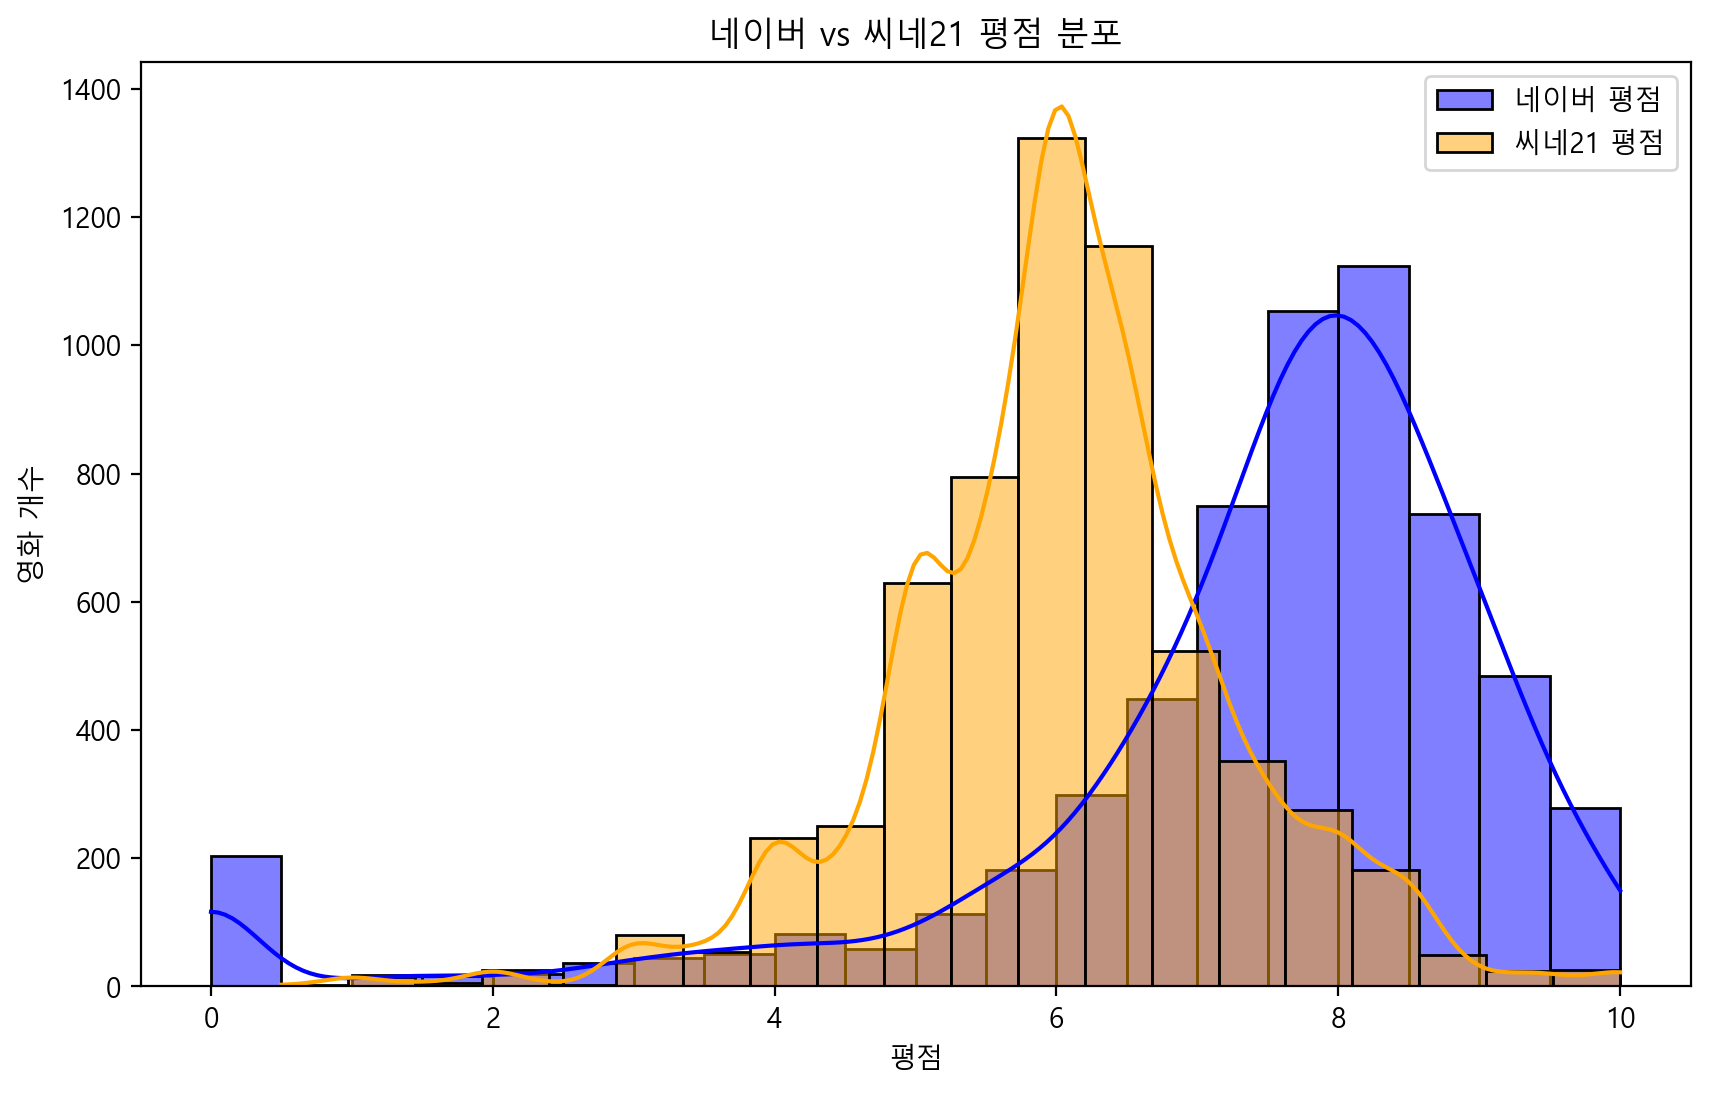

In [61]:
plt.figure(figsize=(10, 6))
sns.histplot(movies_mean['네이버_평점'], kde=True, color='blue', label='네이버 평점', bins=20)
sns.histplot(movies_mean['씨네21_평점'], kde=True, color='orange', label='씨네21 평점', bins=20)
plt.title('네이버 vs 씨네21 평점 분포')
plt.xlabel('평점')
plt.ylabel('영화 개수')
plt.legend()
plt.show()

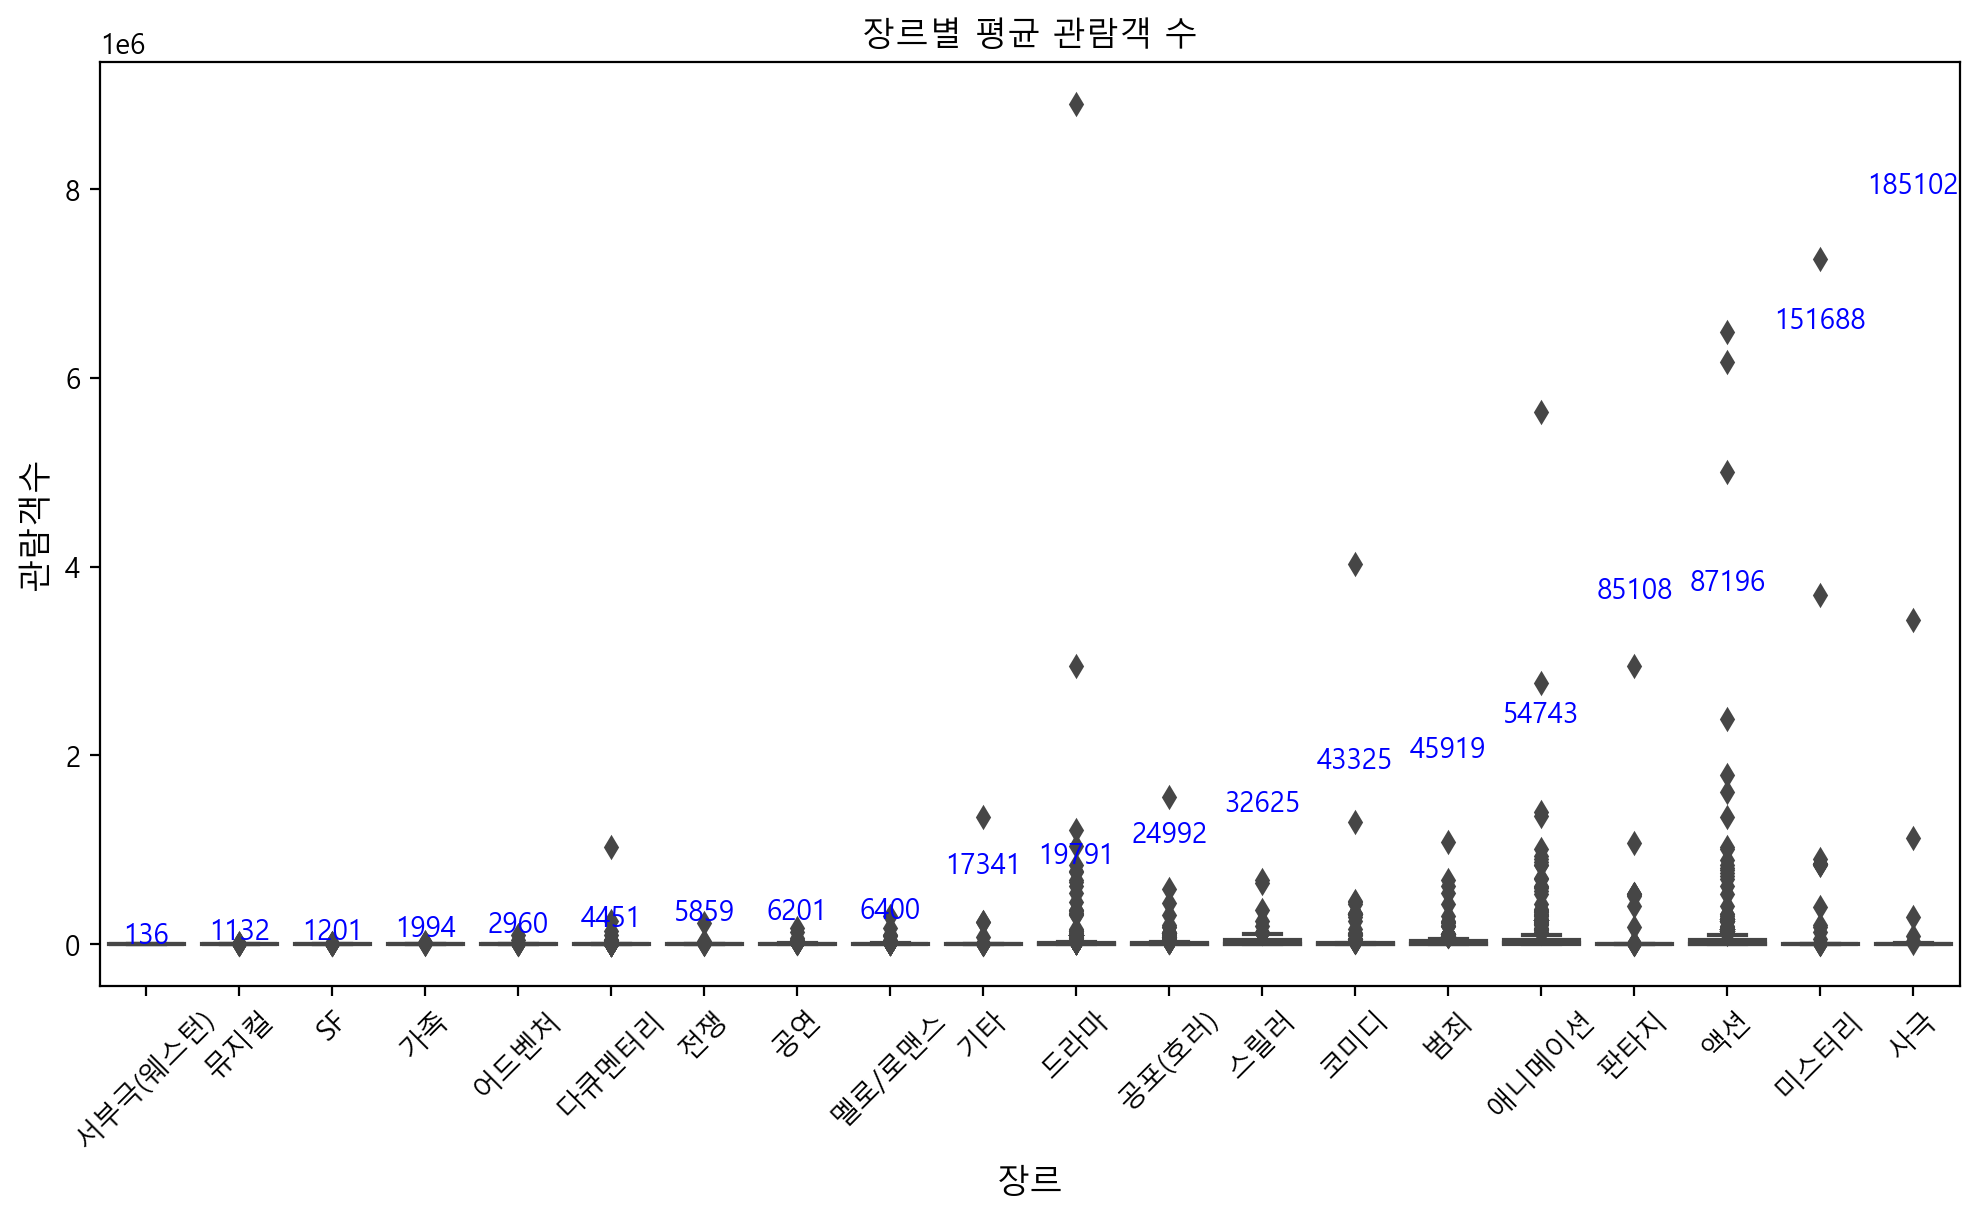

In [195]:
plt.figure(figsize=(12, 6))
sorted_data = movies_mean.groupby('장르')['관람객수'].mean().sort_values(ascending=True).reset_index()
ax = sns.boxplot(data=movies_mean, x='장르', y='관람객수', order=sorted_data['장르'])

for i, genre in enumerate(sorted_data['장르']):
    mean_value = movies_mean[movies_mean['장르'] == genre]['관람객수'].mean()
    ax.text(i, mean_value *43, f'{mean_value:.0f}', color='blue', ha='center')

plt.title('장르별 평균 관람객 수')
plt.xlabel('장르', fontsize=12)
plt.ylabel('관람객수', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.show()

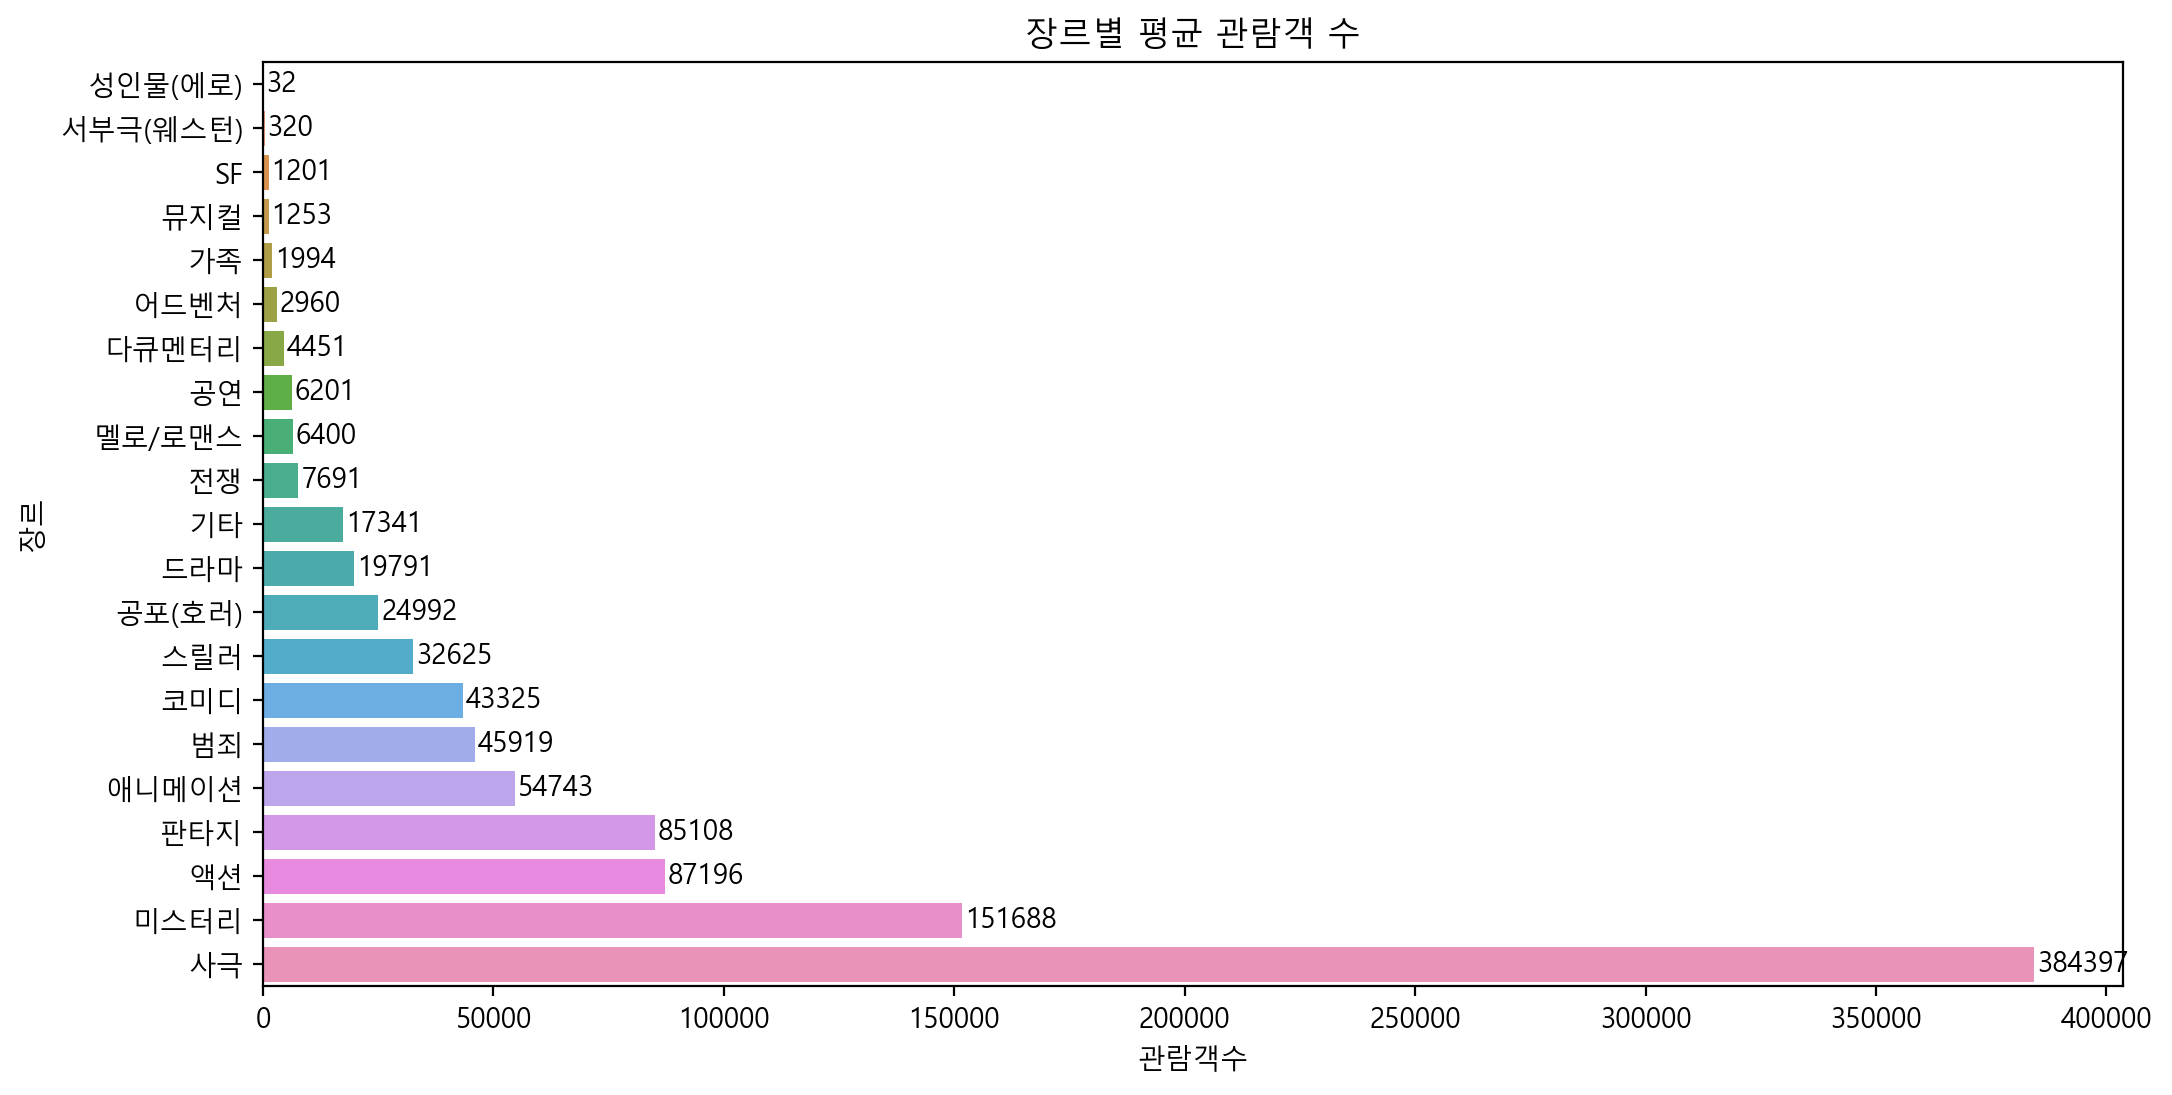

In [62]:
plt.figure(figsize=(12, 6))
sorted_data = movies_mean.groupby('장르')['관람객수'].mean().sort_values(ascending=True).reset_index()
ax = sns.barplot(data=sorted_data, x='관람객수', y='장르', errorbar=None)
for i in ax.containers:
    ax.bar_label(i, fmt='%.0f', padding=1)
plt.title('장르별 평균 관람객 수')
plt.show()

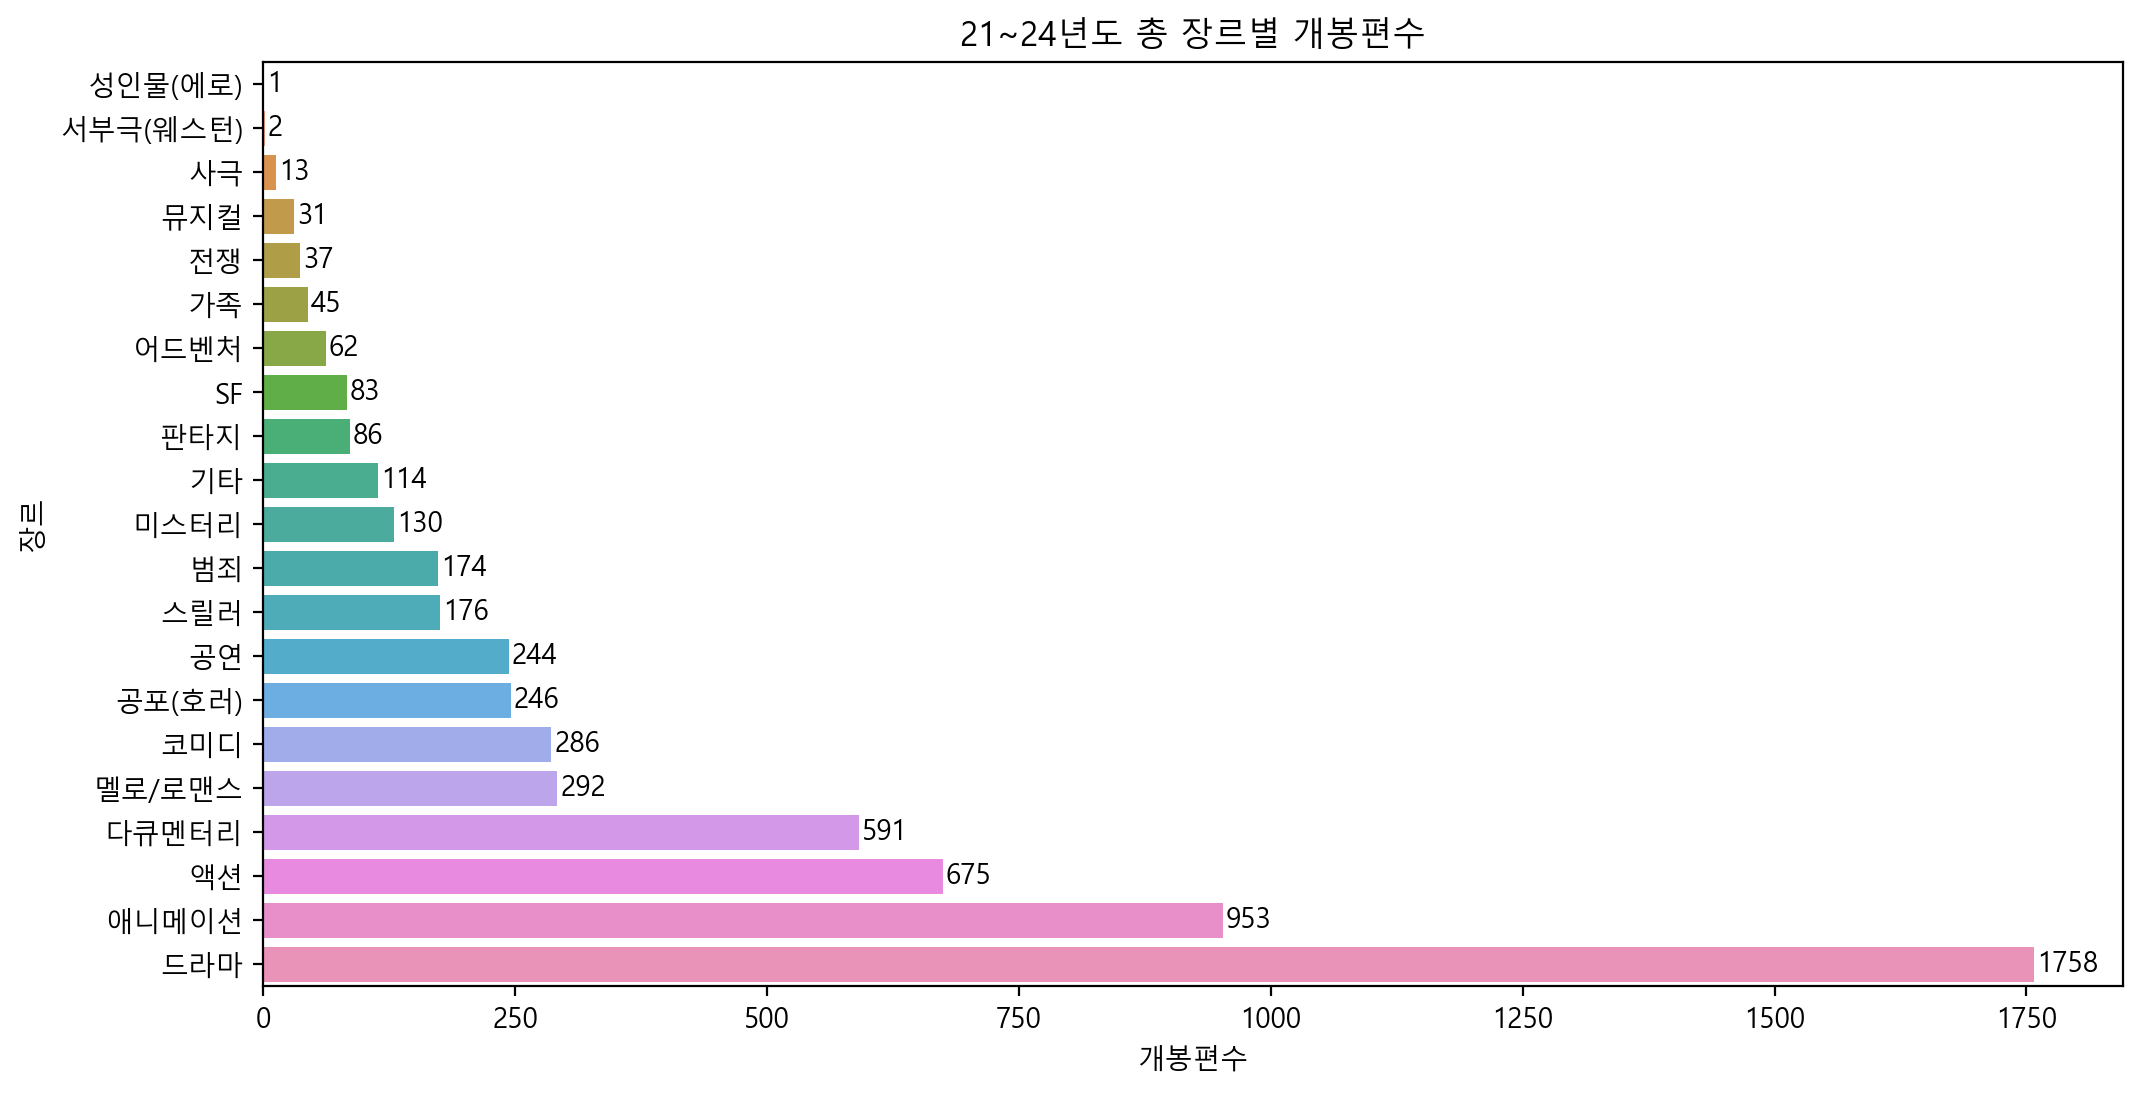

In [63]:
plt.figure(figsize=(12, 6))
sorted_data = movies_mean.groupby('장르')['개봉월'].count().sort_values(ascending=True).reset_index()
ax = sns.barplot(data=sorted_data, x='개봉월', y='장르', errorbar=None)
for i in ax.containers:
    ax.bar_label(i, fmt='%.0f', padding=1)
plt.title('21~24년도 총 장르별 개봉편수')
plt.xlabel('개봉편수')
plt.show()

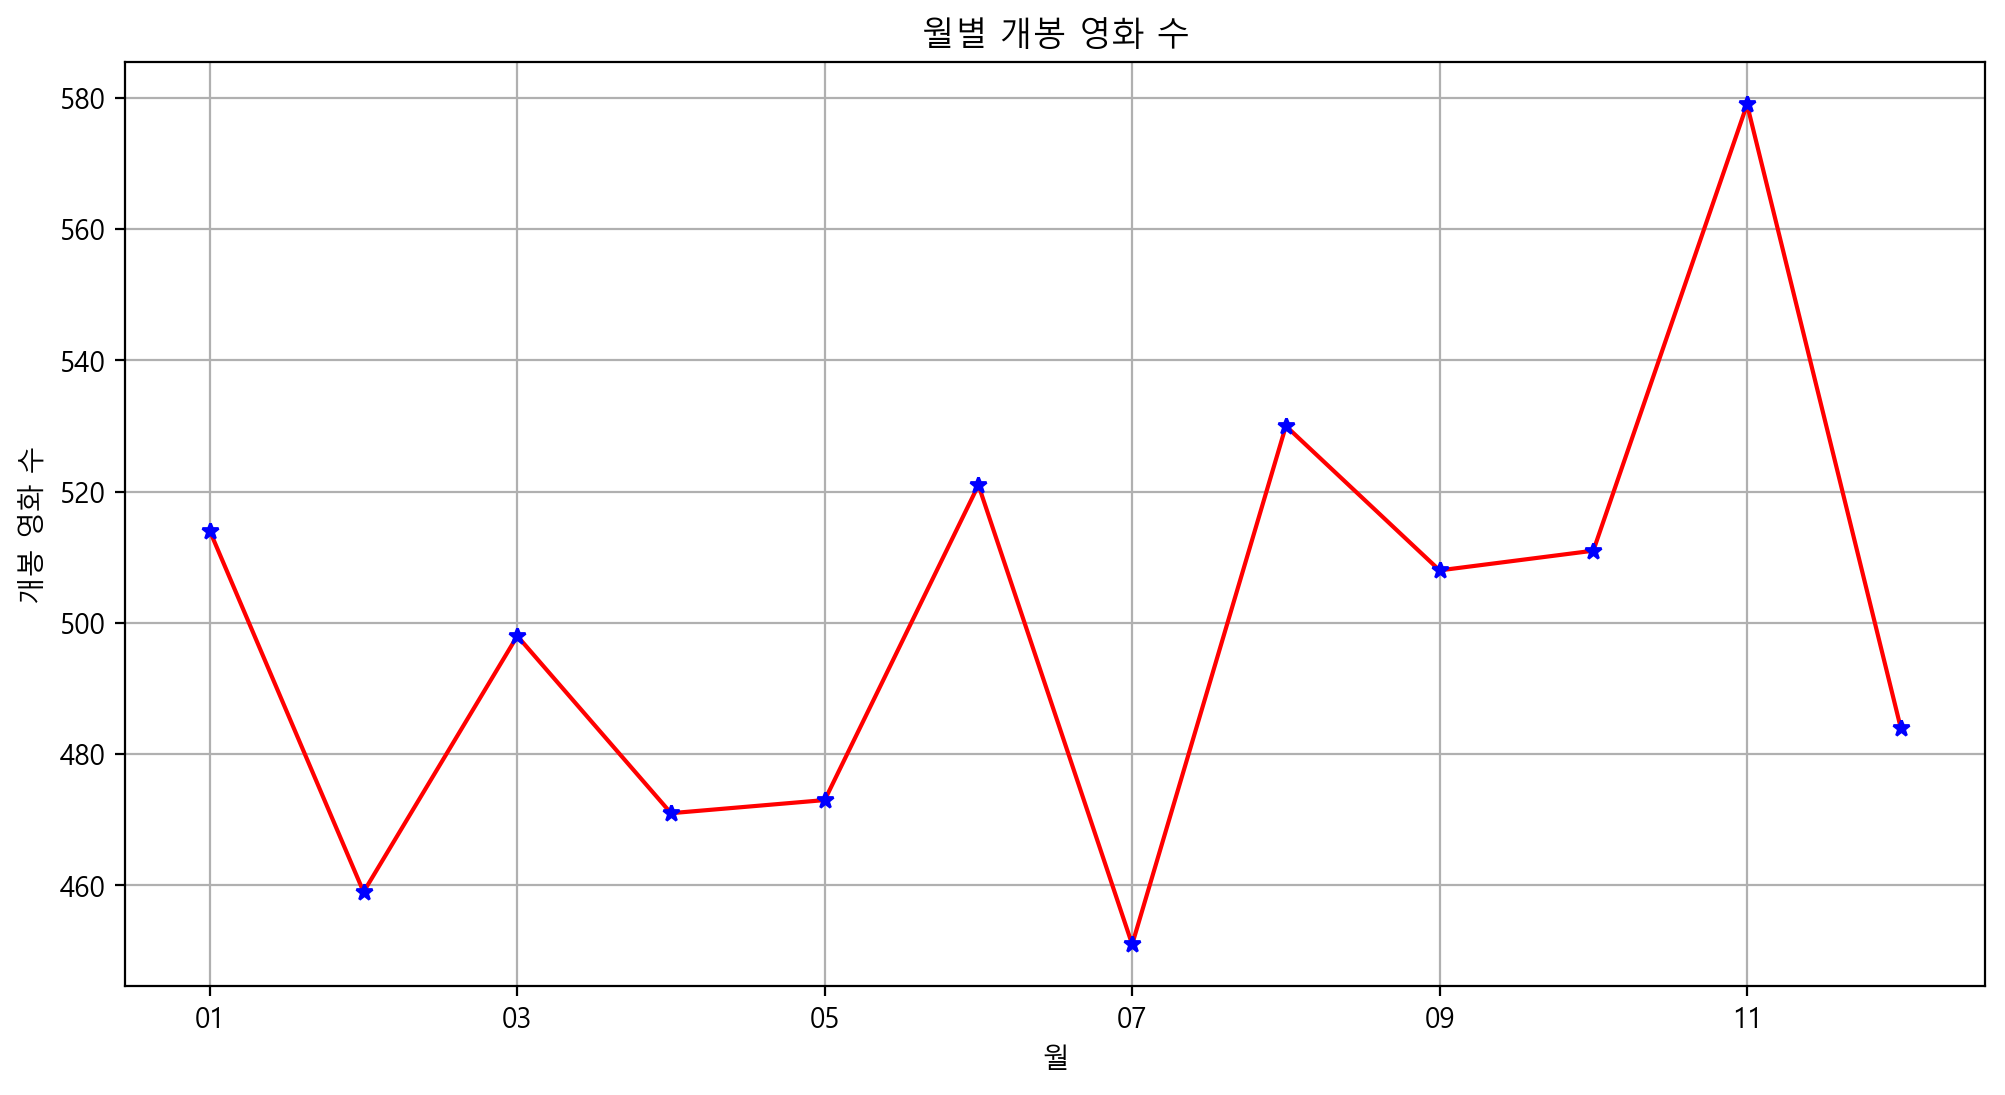

In [64]:
plt.figure(figsize=(12, 6))
plt.rc('font', family='Malgun Gothic')
ax = movies_mean.groupby('개봉월')['영화제목'].count().plot(kind='line', marker='*', markerfacecolor='blue', markeredgecolor='blue', color='red')
plt.title('월별 개봉 영화 수')
plt.xlabel('월')
plt.ylabel('개봉 영화 수')
plt.grid(True)
plt.show()

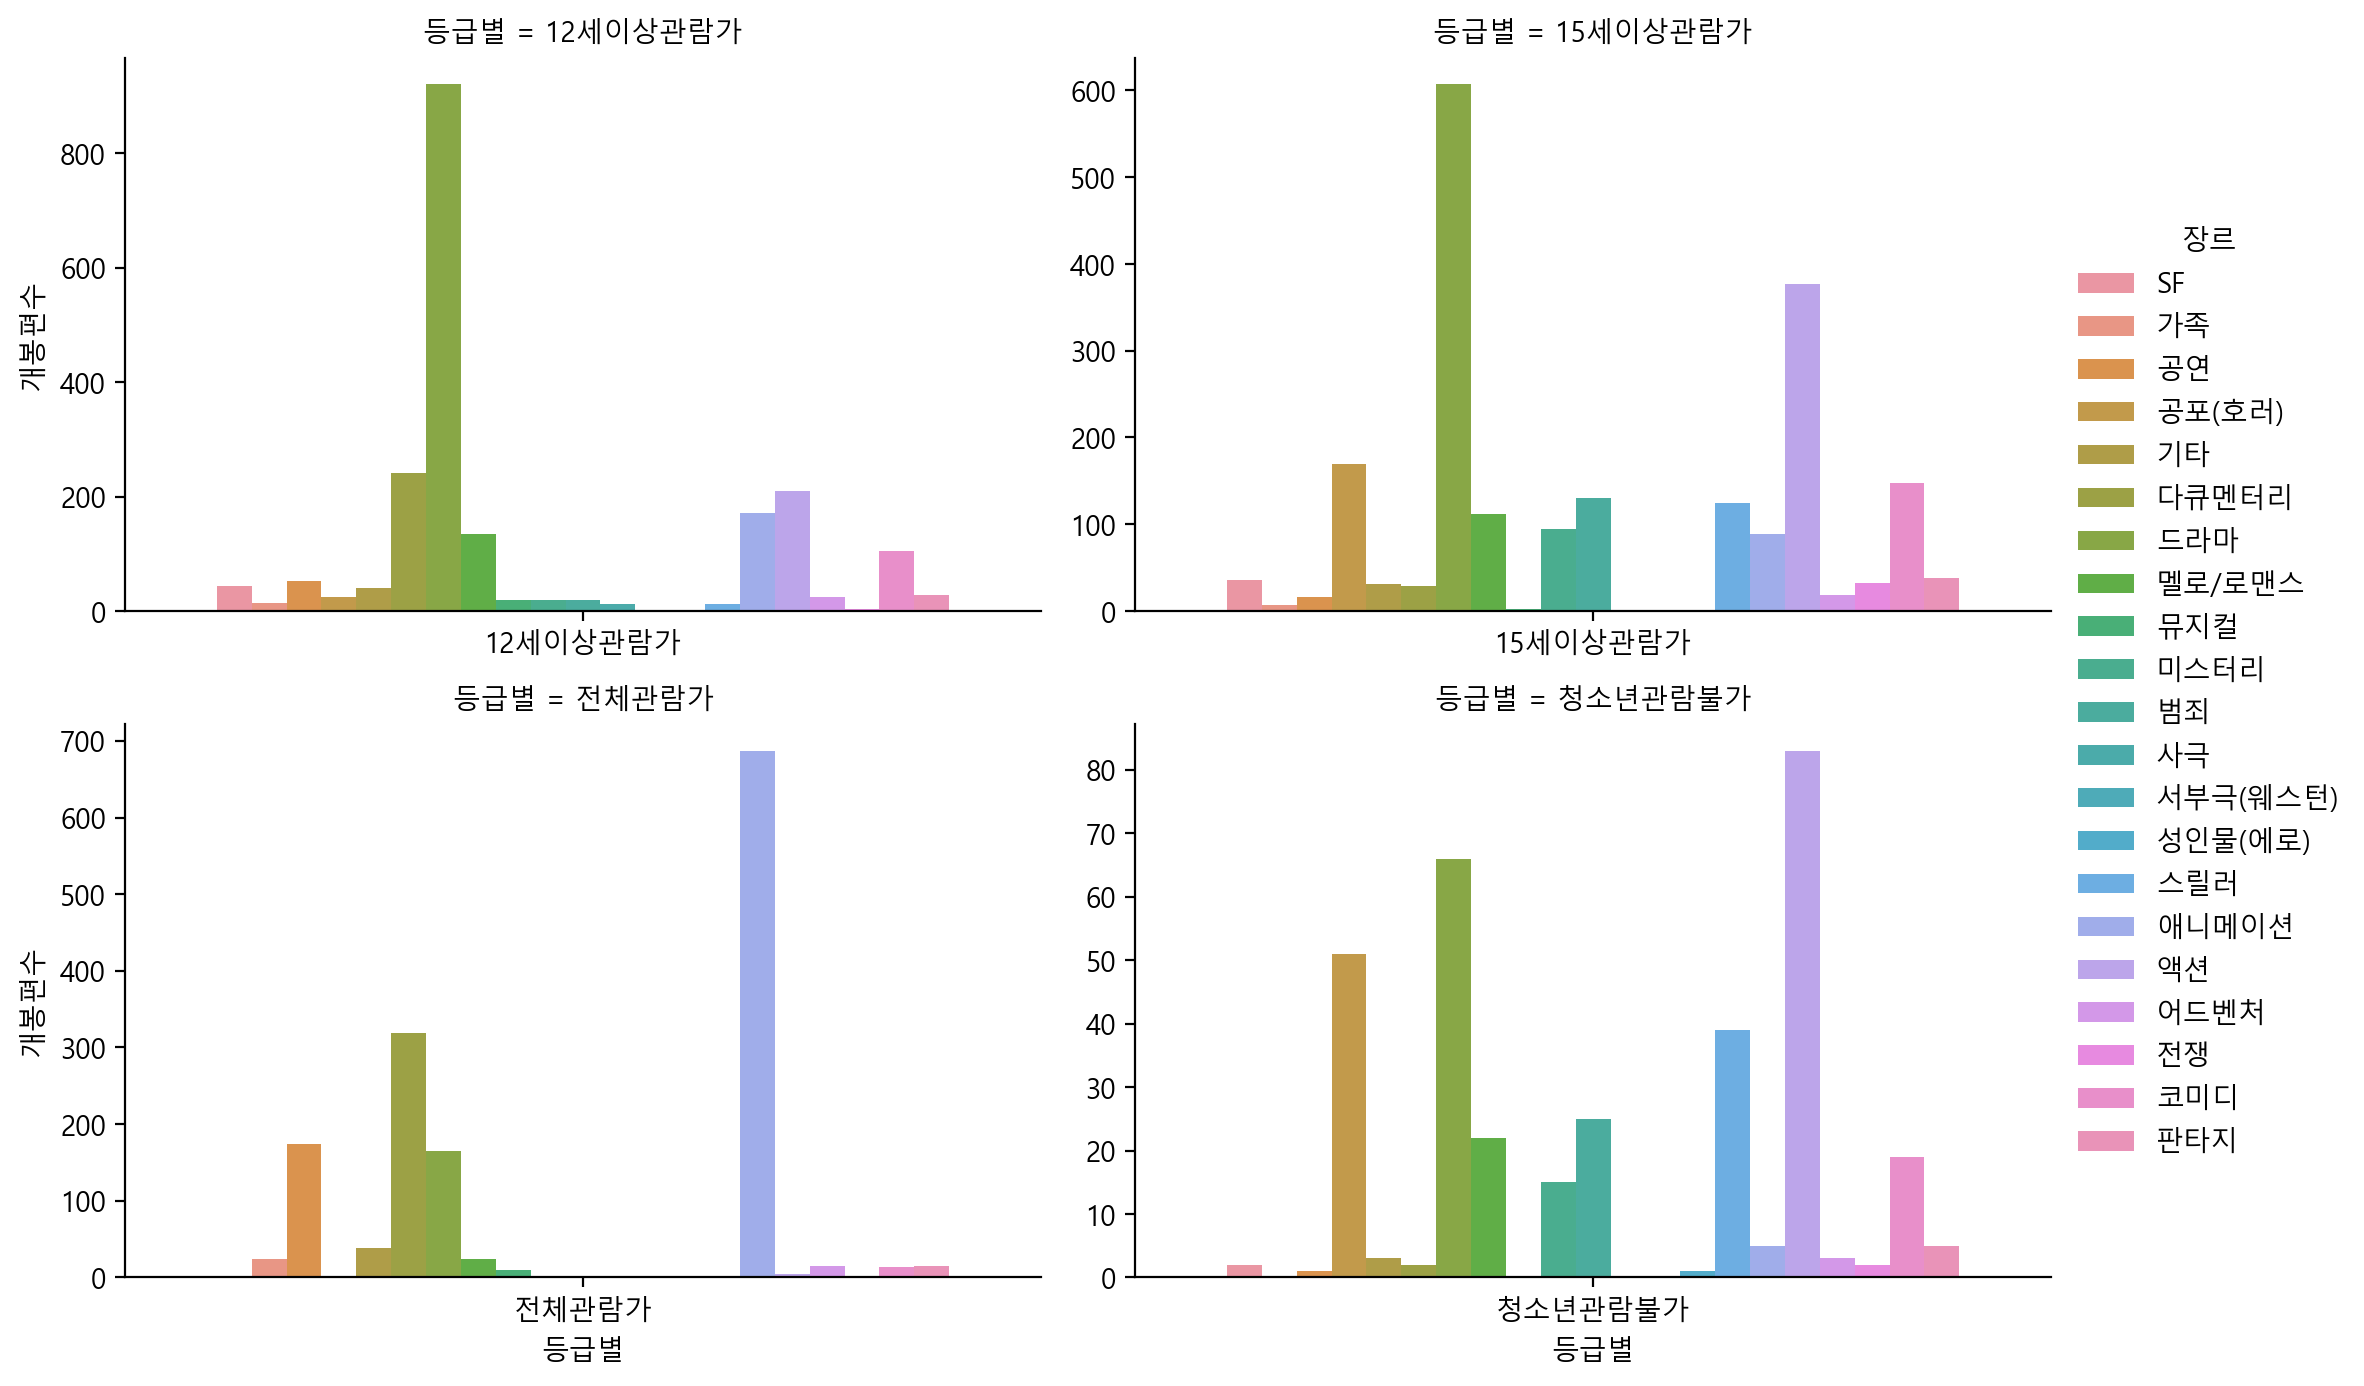

In [65]:
movie_grade = movies_mean.groupby(['장르','등급'])[['개봉월']].count().reset_index()
movie_grade = movie_grade.rename(columns={'장르':'장르',
                    '등급':'등급별',
                    '개봉월':'개봉편수'})
sns.catplot(data=movie_grade, 
            x='등급별', 
            y='개봉편수', 
            hue='장르', 
            kind='bar',
            col='등급별',
            sharey=False,
            sharex=False,
            height=3.5,
            aspect=1.5,
            col_wrap=2)
plt.show()

# DNN (계절예측)

In [264]:
# 월_계절 컬럼 만들기
def movie_season(month):
    if month in [12, 1, 2]:
        return 4
    elif month in [3, 4, 5]:
        return 1
    elif month in [6, 7, 8]:
        return 2
    elif month in [9, 10, 11]:
        return 3

In [265]:
movies_mean['개봉월'] = pd.to_numeric(movies_mean['개봉월'], errors='coerce')
movies_mean['계절'] = movies_mean['개봉월'].apply(movie_season)
movies_mean['계절']

0       4
1       4
2       4
3       4
4       4
       ..
6038    3
6039    2
6040    3
6041    3
6042    2
Name: 계절, Length: 5999, dtype: int64

In [266]:
# 장르2를 만들어 번호와 이름이 같이 출력할수있게 딕셔너리로 변경
movies_genre = {movie:idx   for idx, movie in enumerate(movies_mean['장르'].unique())}
# movies_genre
movies_mean['장르2'] = movies_mean['장르'].map(movies_genre)
print(movies_mean[['장르', '장르2']].head())

      장르  장르2
0  애니메이션    0
1  애니메이션    0
2     액션    1
3    드라마    2
4  애니메이션    0


In [267]:
# 데이터 준비 (분류분석)
# 라벨인코딩 
le = LabelEncoder()
movies_mean['등급_le'] = le.fit_transform(movies_mean['등급'])
movies_mean['관람객수_le'] = le.fit_transform(movies_mean['관람객수'])
movies_mean['계절_le'] = le.fit_transform(movies_mean['계절'])

X = movies_mean[['장르2', '총스크린수', '관람객수_le', '등급_le']]
y = movies_mean['계절_le']

In [268]:
# 데이터 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=38)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4799, 4), (4799,), (1200, 4), (1200,))

In [269]:
# 데이터 스케일링
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [285]:
# 모델준비 (분류분석)
model = Sequential([
    Input(shape=(4,)), # 입력데이터의 colunm 수
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(32, activation='relu'),
    Dense(len(movies_mean['계절_le'].unique()), activation='softmax')  # 계절의 개수만큼 출력층 생성
])

In [286]:
# 모델 컴파일 및 학습
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', # 'sparse_categorical_crossentropy'
              metrics=['accuracy'])

# 모델 저장 경로 
model_save_folder = './model/'
if not os.path.exists(model_save_folder):
    os.mkdir(model_save_folder)  # model_save_folder가 없으면 폴더 생성

# 조기 종료 콜백
earlyStopping = EarlyStopping(patience=50)

# 모델 자동 저장 콜백 객체
file = model_save_folder+ 'movies_sea-{epoch:03d}-val{val_accuracy:.4f}.h5'
checkpoint = ModelCheckpoint(filepath=file,          
                            monitor='val_accuracy',  # 모니터링할 지표
                            save_best_only=True,     # 모니터링한 지표가 개선된 경우만 저장. False면 매번 저장.
                            mode='max',              # 값이 클수록 저장. 'min':값이 작을수록 저장. 'auto':모니터링에 의해 자동 저장.
                            verbose=1)               

hist = model.fit(X_train, y_train, 
                 epochs = 500, 
                 validation_split = 0.2, 
                 callbacks = earlyStopping
                )

Epoch 1/500
120/120 [==============================] - 1s 7ms/step - loss: 1.3863 - accuracy: 0.2667 - val_loss: 1.3780 - val_accuracy: 0.2792
Epoch 2/500
120/120 [==============================] - 1s 5ms/step - loss: 1.3795 - accuracy: 0.2772 - val_loss: 1.3764 - val_accuracy: 0.2844
Epoch 3/500
120/120 [==============================] - 1s 5ms/step - loss: 1.3773 - accuracy: 0.2871 - val_loss: 1.3753 - val_accuracy: 0.2948
Epoch 4/500
120/120 [==============================] - 1s 5ms/step - loss: 1.3774 - accuracy: 0.2873 - val_loss: 1.3699 - val_accuracy: 0.3021
Epoch 5/500
120/120 [==============================] - 1s 5ms/step - loss: 1.3734 - accuracy: 0.3014 - val_loss: 1.3699 - val_accuracy: 0.3177
Epoch 6/500
120/120 [==============================] - 1s 5ms/step - loss: 1.3704 - accuracy: 0.3058 - val_loss: 1.3701 - val_accuracy: 0.3031
Epoch 7/500
120/120 [==============================] - 1s 5ms/step - loss: 1.3685 - accuracy: 0.3131 - val_loss: 1.3715 - val_accuracy: 0.3073

Epoch 58/500
120/120 [==============================] - 1s 5ms/step - loss: 1.2881 - accuracy: 0.3936 - val_loss: 1.3221 - val_accuracy: 0.3448
Epoch 59/500
120/120 [==============================] - 1s 5ms/step - loss: 1.2834 - accuracy: 0.3813 - val_loss: 1.3217 - val_accuracy: 0.3562
Epoch 60/500
120/120 [==============================] - 1s 6ms/step - loss: 1.2822 - accuracy: 0.3897 - val_loss: 1.3234 - val_accuracy: 0.3510
Epoch 61/500
120/120 [==============================] - 1s 6ms/step - loss: 1.2883 - accuracy: 0.3920 - val_loss: 1.3231 - val_accuracy: 0.3573
Epoch 62/500
120/120 [==============================] - 1s 5ms/step - loss: 1.2824 - accuracy: 0.3910 - val_loss: 1.3289 - val_accuracy: 0.3375
Epoch 63/500
120/120 [==============================] - 1s 7ms/step - loss: 1.2737 - accuracy: 0.3933 - val_loss: 1.3212 - val_accuracy: 0.3521
Epoch 64/500
120/120 [==============================] - 1s 5ms/step - loss: 1.2841 - accuracy: 0.3876 - val_loss: 1.3245 - val_accuracy:

Epoch 115/500
120/120 [==============================] - 1s 5ms/step - loss: 1.2178 - accuracy: 0.4358 - val_loss: 1.2916 - val_accuracy: 0.3844
Epoch 116/500
120/120 [==============================] - 1s 5ms/step - loss: 1.2230 - accuracy: 0.4314 - val_loss: 1.2881 - val_accuracy: 0.3844
Epoch 117/500
120/120 [==============================] - 1s 5ms/step - loss: 1.2123 - accuracy: 0.4379 - val_loss: 1.2841 - val_accuracy: 0.3948
Epoch 118/500
120/120 [==============================] - 1s 5ms/step - loss: 1.2131 - accuracy: 0.4345 - val_loss: 1.2950 - val_accuracy: 0.3948
Epoch 119/500
120/120 [==============================] - 1s 5ms/step - loss: 1.2147 - accuracy: 0.4392 - val_loss: 1.2899 - val_accuracy: 0.3844
Epoch 120/500
120/120 [==============================] - 1s 6ms/step - loss: 1.2126 - accuracy: 0.4306 - val_loss: 1.2921 - val_accuracy: 0.3885
Epoch 121/500
120/120 [==============================] - 1s 5ms/step - loss: 1.2142 - accuracy: 0.4340 - val_loss: 1.2911 - val_ac

120/120 [==============================] - 1s 6ms/step - loss: 1.1661 - accuracy: 0.4652 - val_loss: 1.2783 - val_accuracy: 0.4042
Epoch 172/500
120/120 [==============================] - 1s 5ms/step - loss: 1.1744 - accuracy: 0.4548 - val_loss: 1.2855 - val_accuracy: 0.4052
Epoch 173/500
120/120 [==============================] - 1s 6ms/step - loss: 1.1688 - accuracy: 0.4592 - val_loss: 1.2774 - val_accuracy: 0.4083
Epoch 174/500
120/120 [==============================] - 1s 5ms/step - loss: 1.1750 - accuracy: 0.4634 - val_loss: 1.2845 - val_accuracy: 0.4021
Epoch 175/500
120/120 [==============================] - 1s 5ms/step - loss: 1.1724 - accuracy: 0.4525 - val_loss: 1.2843 - val_accuracy: 0.4052
Epoch 176/500
120/120 [==============================] - 1s 5ms/step - loss: 1.1687 - accuracy: 0.4543 - val_loss: 1.2805 - val_accuracy: 0.4052
Epoch 177/500
120/120 [==============================] - 1s 6ms/step - loss: 1.1714 - accuracy: 0.4624 - val_loss: 1.2889 - val_accuracy: 0.3823

In [287]:
# 모델 평가하기 
loss, accuracy = model.evaluate(X_test, y_test)
print('accuracy : {:.2f}'.format(accuracy*100), '%')

38/38 [==============================] - 0s 4ms/step - loss: 1.3657 - accuracy: 0.3925
accuracy : 39.25 %


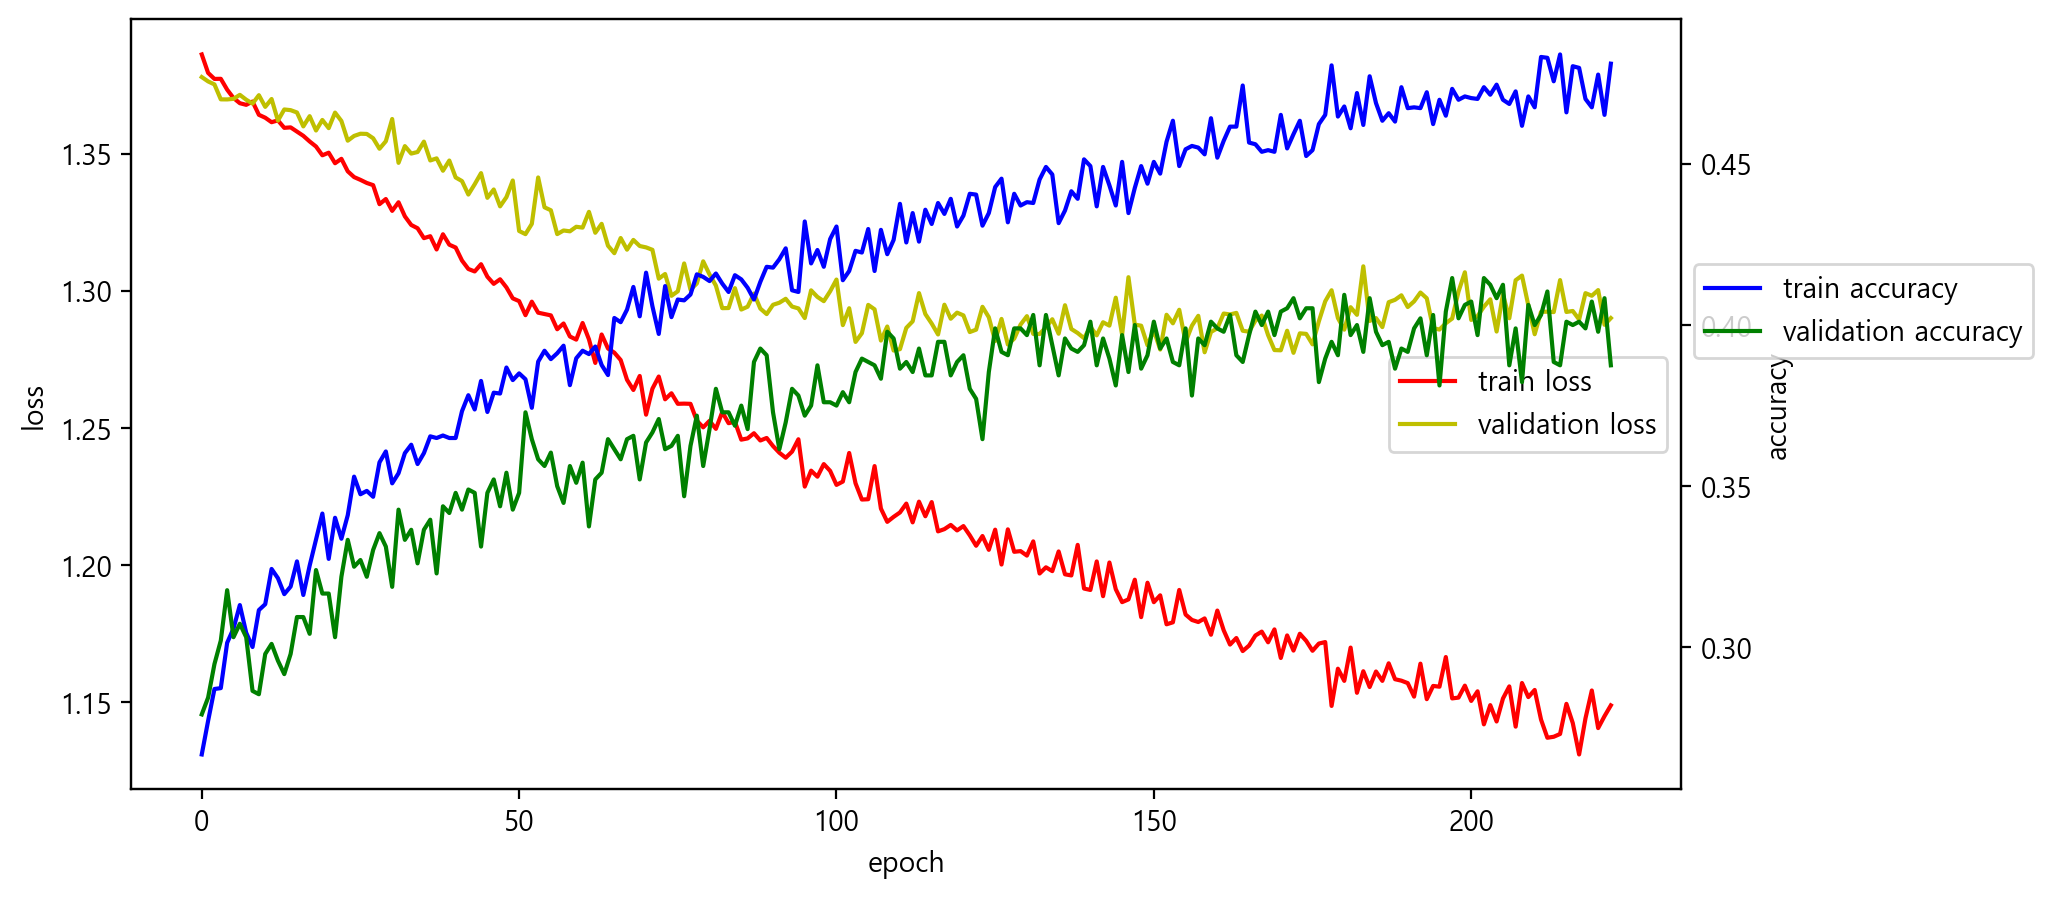

In [288]:
# 학습과정 표시하기
fig, loss_ax = plt.subplots(figsize=(10,5))
loss_ax.plot(hist.history['loss'], 'r', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'y', label='validation loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='validation accuracy')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='center right')
acc_ax.legend(bbox_to_anchor=(0.999, 0.7))
plt.show()

# DNN (관객수 등급 예측)

In [248]:
movies_mean['관객수_등급'] = pd.qcut(
    movies_mean['관람객수'], 
    q= 3, 
    labels=range(1, 4)  # 구간을 숫자로 변환
)
print(movies_mean[['관객수_등급','관람객수']])

     관객수_등급      관람객수
0         3  875001.0
1         3  206309.0
2         3  155562.0
3         3   42290.0
4         3   38131.0
...     ...       ...
6038      2     676.0
6039      2     674.0
6040      2     652.0
6041      2     609.0
6042      2     582.0

[5999 rows x 2 columns]


In [249]:
# 관객수_순위 타입변환
movies_mean['관객수_등급'] = movies_mean['관객수_등급'].astype(int)
print(movies_mean[['관객수_등급','관람객수']].sample(5))

      관객수_등급          관람객수
3268       2    686.606323
4663       3  62624.000000
3609       1      3.000000
1170       2    360.000000
5085       2    362.000000


In [250]:
# 라벨인코딩 
le = LabelEncoder()
movies_mean['등급_le'] = le.fit_transform(movies_mean['등급'])
movies_mean['계절_le'] = le.fit_transform(movies_mean['월_계절'])

# 데이터 준비 
x = movies_mean[['장르2', '계절_le','총스크린수', '등급_le']]
y = movies_mean['관객수_등급']
# y 원핫인코딩
y = to_categorical(y) # y 원핫인코딩

In [251]:
# 데이터 나누기
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=38)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4799, 4), (4799, 4), (1200, 4), (1200, 4))

In [252]:
# 데이터 스케일링
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [255]:
# 모델준비 (분류분석)
model = Sequential([
    Input(shape=(4,)),  # 입력
    Dense(128, activation=
          'relu'),# 은닉층
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dense(64, activation='relu'), 
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(4, activation='softmax') # 출력층
])
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_85 (Dense)            (None, 128)               640       
                                                                 
 dropout_34 (Dropout)        (None, 128)               0         
                                                                 
 dense_86 (Dense)            (None, 256)               33024     
                                                                 
 dense_87 (Dense)            (None, 64)                16448     
                                                                 
 dropout_35 (Dropout)        (None, 64)                0         
                                                                 
 dense_88 (Dense)            (None, 64)                4160      
                                                                 
 dense_89 (Dense)            (None, 4)               

In [256]:
# 모델 컴파일 및 학습
model.compile(optimizer='adam', 
              loss='categorical_crossentropy',  # 원-핫 인코딩된 y_train 사용 시
              metrics=['accuracy'])

# 모델 저장 경로 
model_save_folder = './model/'
if not os.path.exists(model_save_folder):
    os.mkdir(model_save_folder)  # model_save_folder가 없으면 폴더 생성

# 조기 종료 콜백
earlyStopping = EarlyStopping(patience=50)
# 모델 자동 저장 콜백 객체
file = model_save_folder+ 'movies_aud-{epoch:03d}-val{val_accuracy:.4f}.h5'
checkpoint = ModelCheckpoint(filepath=file,          # 저장경로
                            monitor='val_accuracy',  # 모니터링할 지표
                            save_best_only=True,     # 모니터링한 지표가 개선된 경우만 저장. False면 매번 저장.
                            mode='max',              # 값이 클수록 저장. 'min':값이 작을수록 저장. 'auto':모니터링에 의해 자동 저장.
                             verbos=1)               # 저장 여부 로그 출력 (0:출력 안 함)

hist = model.fit(X_train, y_train, 
                 epochs=500, 
                 validation_split=0.2, 
                 callbacks=[checkpoint, earlyStopping])

Epoch 1/500
120/120 [==============================] - 1s 7ms/step - loss: 1.1044 - accuracy: 0.4183 - val_loss: 1.0224 - val_accuracy: 0.4875
Epoch 2/500
120/120 [==============================] - 1s 6ms/step - loss: 1.0298 - accuracy: 0.4772 - val_loss: 1.0059 - val_accuracy: 0.5021
Epoch 3/500
120/120 [==============================] - 1s 5ms/step - loss: 1.0183 - accuracy: 0.4801 - val_loss: 0.9904 - val_accuracy: 0.4948
Epoch 4/500
120/120 [==============================] - 1s 6ms/step - loss: 1.0109 - accuracy: 0.4996 - val_loss: 0.9804 - val_accuracy: 0.5177
Epoch 5/500
120/120 [==============================] - 1s 6ms/step - loss: 1.0032 - accuracy: 0.5030 - val_loss: 0.9712 - val_accuracy: 0.5250
Epoch 6/500
120/120 [==============================] - 1s 5ms/step - loss: 0.9898 - accuracy: 0.5145 - val_loss: 0.9634 - val_accuracy: 0.5219
Epoch 7/500
120/120 [==============================] - 1s 5ms/step - loss: 0.9853 - accuracy: 0.5074 - val_loss: 0.9595 - val_accuracy: 0.5271

Epoch 58/500
120/120 [==============================] - 1s 5ms/step - loss: 0.9043 - accuracy: 0.5595 - val_loss: 0.9073 - val_accuracy: 0.5583
Epoch 59/500
120/120 [==============================] - 1s 5ms/step - loss: 0.8962 - accuracy: 0.5694 - val_loss: 0.9098 - val_accuracy: 0.5604
Epoch 60/500
120/120 [==============================] - 1s 6ms/step - loss: 0.8960 - accuracy: 0.5663 - val_loss: 0.9003 - val_accuracy: 0.5646
Epoch 61/500
120/120 [==============================] - 1s 5ms/step - loss: 0.8986 - accuracy: 0.5645 - val_loss: 0.9042 - val_accuracy: 0.5604
Epoch 62/500
120/120 [==============================] - 1s 6ms/step - loss: 0.8973 - accuracy: 0.5699 - val_loss: 0.9029 - val_accuracy: 0.5594
Epoch 63/500
120/120 [==============================] - 1s 5ms/step - loss: 0.8963 - accuracy: 0.5598 - val_loss: 0.9046 - val_accuracy: 0.5562
Epoch 64/500
120/120 [==============================] - 1s 5ms/step - loss: 0.8958 - accuracy: 0.5666 - val_loss: 0.9076 - val_accuracy:

Epoch 115/500
120/120 [==============================] - 1s 5ms/step - loss: 0.8621 - accuracy: 0.5830 - val_loss: 0.9124 - val_accuracy: 0.5562
Epoch 116/500
120/120 [==============================] - 1s 5ms/step - loss: 0.8563 - accuracy: 0.5759 - val_loss: 0.9143 - val_accuracy: 0.5385


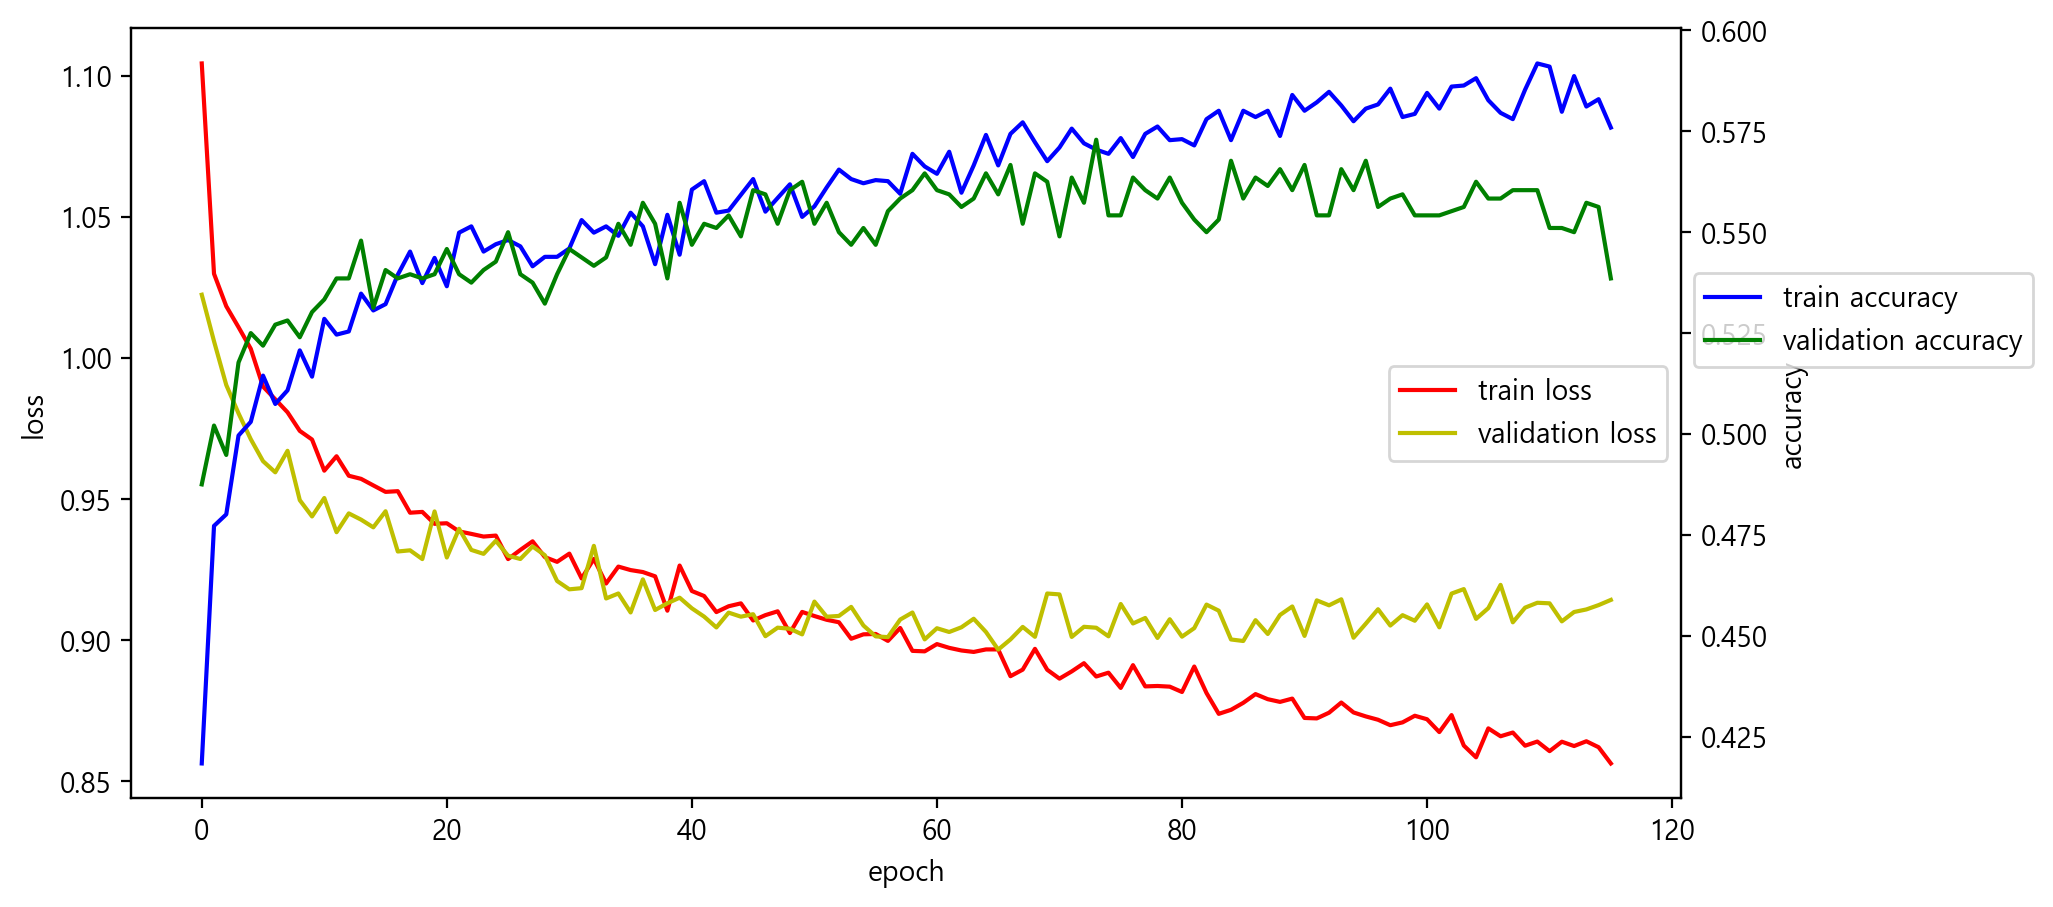

In [257]:
# 학습과정 표시하기
fig, loss_ax = plt.subplots(figsize=(10,5))
loss_ax.plot(hist.history['loss'], 'r', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'y', label='validation loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='validation accuracy')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='center right')
acc_ax.legend(bbox_to_anchor=(0.999, 0.7))
plt.show()

In [258]:
# 모델 평가하기 
loss, accuracy = model.evaluate(X_test, y_test)
print('accuracy : {:.2f}'.format(accuracy*100), '%')

38/38 [==============================] - 0s 3ms/step - loss: 0.9680 - accuracy: 0.5633
accuracy : 56.33 %


In [259]:
# 모델 평가
y_hat = model.predict(X_test).argmax(axis=1)
y_test = np.argmax(y_test, axis=1)
print(confusion_matrix(y_test, y_hat))
print('f1 score:', f1_score(y_test, y_hat, average='macro'))
# 크로스탭 
pd.crosstab(y_test, # 실제값(1차원) 
            y_hat.reshape(-1) # 예측값(1차원)    
           )

38/38 [==============================] - 0s 1ms/step
[[174 117  75]
 [ 97 204 124]
 [ 27  84 298]]
f1 score: 0.5578330983980071


col_0,1,2,3
row_0,,,
1,174,117,75
2,97,204,124
3,27,84,298


# SMOTE 데이터 증강 학습 (계절예측)

In [329]:
# 데이터 준비 (분류분석)
# 라벨인코딩 
le = LabelEncoder()
movies_mean['등급_le'] = le.fit_transform(movies_mean['등급'])
movies_mean['관람객수_le'] = le.fit_transform(movies_mean['관람객수'])
movies_mean['계절_le'] = le.fit_transform(movies_mean['계절'])

x = movies_mean[['장르2','총스크린수','관람객수_le', '등급_le']]
y = movies_mean['계절_le']

In [330]:
# 데이터 나누기
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=38)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4799, 4), (4799,), (1200, 4), (1200,))

In [336]:
# 데이터 증강
smote = SMOTE(random_state=38, k_neighbors=2)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print("비조정 SMOTE", Counter(y_train))
print("조정 SMOTE:", Counter(y_train_smote))

비조정 SMOTE Counter({2: 1305, 1: 1222, 0: 1140, 3: 1132})
조정 SMOTE: Counter({3: 1305, 2: 1305, 0: 1305, 1: 1305})


In [337]:
# 데이터 스케일링
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [338]:
# 모델준비 (분류분석)
model = Sequential([
    Input(shape=(4,)), # 입력데이터의 colunm 수
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(32, activation='relu'),
    Dense(len(movies_mean['계절_le'].unique()), activation='softmax')  # 계절의 개수만큼 출력층 생성
])

In [339]:
# 모델 컴파일 및 학습
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', # 'sparse_categorical_crossentropy'
              metrics=['accuracy'])

# 모델 저장 경로 
model_save_folder = './model/'
if not os.path.exists(model_save_folder):
    os.mkdir(model_save_folder)  # model_save_folder가 없으면 폴더 생성

# 조기 종료 콜백
earlyStopping = EarlyStopping(patience=50)

# 모델 자동 저장 콜백 객체
file = model_save_folder+ 'movies_up-{epoch:03d}-val{val_accuracy:.4f}.h5'
checkpoint = ModelCheckpoint(filepath=file,          
                            monitor='val_accuracy',  # 모니터링할 지표
                            save_best_only=True,     # 모니터링한 지표가 개선된 경우만 저장. False면 매번 저장.
                            mode='max',              # 값이 클수록 저장. 'min':값이 작을수록 저장. 'auto':모니터링에 의해 자동 저장.
                             verbos=1)               

hist = model.fit(X_train_smote, y_train_smote, 
                 epochs = 500, 
                 validation_split = 0.2, 
                 callbacks = earlyStopping
                )

Epoch 1/500
131/131 [==============================] - 1s 7ms/step - loss: 1.3873 - accuracy: 0.2610 - val_loss: 1.4006 - val_accuracy: 0.1897
Epoch 2/500
131/131 [==============================] - 1s 6ms/step - loss: 1.3793 - accuracy: 0.2847 - val_loss: 1.3921 - val_accuracy: 0.2088
Epoch 3/500
131/131 [==============================] - 1s 7ms/step - loss: 1.3776 - accuracy: 0.2859 - val_loss: 1.3836 - val_accuracy: 0.2816
Epoch 4/500
131/131 [==============================] - 1s 6ms/step - loss: 1.3779 - accuracy: 0.2931 - val_loss: 1.3906 - val_accuracy: 0.2500
Epoch 5/500
131/131 [==============================] - 1s 5ms/step - loss: 1.3746 - accuracy: 0.2981 - val_loss: 1.4057 - val_accuracy: 0.1801
Epoch 6/500
131/131 [==============================] - 1s 5ms/step - loss: 1.3722 - accuracy: 0.3022 - val_loss: 1.3805 - val_accuracy: 0.2347
Epoch 7/500
131/131 [==============================] - 1s 5ms/step - loss: 1.3734 - accuracy: 0.2960 - val_loss: 1.3841 - val_accuracy: 0.2270

Epoch 58/500
131/131 [==============================] - 1s 5ms/step - loss: 1.2894 - accuracy: 0.3875 - val_loss: 1.3145 - val_accuracy: 0.3410
Epoch 59/500
131/131 [==============================] - 1s 5ms/step - loss: 1.2780 - accuracy: 0.3925 - val_loss: 1.2975 - val_accuracy: 0.3745
Epoch 60/500
131/131 [==============================] - 1s 5ms/step - loss: 1.2795 - accuracy: 0.3898 - val_loss: 1.2982 - val_accuracy: 0.3736
Epoch 61/500
131/131 [==============================] - 1s 6ms/step - loss: 1.2875 - accuracy: 0.3810 - val_loss: 1.2939 - val_accuracy: 0.3649
Epoch 62/500
131/131 [==============================] - 1s 6ms/step - loss: 1.2833 - accuracy: 0.3973 - val_loss: 1.3087 - val_accuracy: 0.3621
Epoch 63/500
131/131 [==============================] - 1s 5ms/step - loss: 1.2773 - accuracy: 0.3927 - val_loss: 1.2974 - val_accuracy: 0.3678
Epoch 64/500
131/131 [==============================] - 1s 5ms/step - loss: 1.2764 - accuracy: 0.3882 - val_loss: 1.3193 - val_accuracy:

Epoch 115/500
131/131 [==============================] - 1s 5ms/step - loss: 1.2128 - accuracy: 0.4339 - val_loss: 1.2492 - val_accuracy: 0.3985
Epoch 116/500
131/131 [==============================] - 1s 5ms/step - loss: 1.2096 - accuracy: 0.4428 - val_loss: 1.2521 - val_accuracy: 0.4109
Epoch 117/500
131/131 [==============================] - 1s 5ms/step - loss: 1.2157 - accuracy: 0.4370 - val_loss: 1.2575 - val_accuracy: 0.4080
Epoch 118/500
131/131 [==============================] - 1s 5ms/step - loss: 1.2019 - accuracy: 0.4454 - val_loss: 1.2505 - val_accuracy: 0.4186
Epoch 119/500
131/131 [==============================] - 1s 6ms/step - loss: 1.2053 - accuracy: 0.4399 - val_loss: 1.2598 - val_accuracy: 0.4042
Epoch 120/500
131/131 [==============================] - 1s 5ms/step - loss: 1.2122 - accuracy: 0.4318 - val_loss: 1.2481 - val_accuracy: 0.4100
Epoch 121/500
131/131 [==============================] - 1s 5ms/step - loss: 1.2039 - accuracy: 0.4258 - val_loss: 1.2556 - val_ac

131/131 [==============================] - 1s 5ms/step - loss: 1.1754 - accuracy: 0.4526 - val_loss: 1.2457 - val_accuracy: 0.4215
Epoch 172/500
131/131 [==============================] - 1s 5ms/step - loss: 1.1801 - accuracy: 0.4500 - val_loss: 1.2278 - val_accuracy: 0.4253
Epoch 173/500
131/131 [==============================] - 1s 5ms/step - loss: 1.1687 - accuracy: 0.4607 - val_loss: 1.2263 - val_accuracy: 0.4215
Epoch 174/500
131/131 [==============================] - 1s 5ms/step - loss: 1.1611 - accuracy: 0.4593 - val_loss: 1.2387 - val_accuracy: 0.4282
Epoch 175/500
131/131 [==============================] - 1s 6ms/step - loss: 1.1698 - accuracy: 0.4567 - val_loss: 1.2327 - val_accuracy: 0.4224
Epoch 176/500
131/131 [==============================] - 1s 5ms/step - loss: 1.1642 - accuracy: 0.4591 - val_loss: 1.2402 - val_accuracy: 0.4234
Epoch 177/500
131/131 [==============================] - 1s 6ms/step - loss: 1.1678 - accuracy: 0.4547 - val_loss: 1.2226 - val_accuracy: 0.4310

131/131 [==============================] - 1s 5ms/step - loss: 1.1378 - accuracy: 0.4770 - val_loss: 1.2233 - val_accuracy: 0.4502
Epoch 228/500
131/131 [==============================] - 1s 6ms/step - loss: 1.1387 - accuracy: 0.4749 - val_loss: 1.2051 - val_accuracy: 0.4492
Epoch 229/500
131/131 [==============================] - 1s 6ms/step - loss: 1.1280 - accuracy: 0.4744 - val_loss: 1.2274 - val_accuracy: 0.4339
Epoch 230/500
131/131 [==============================] - 1s 6ms/step - loss: 1.1360 - accuracy: 0.4691 - val_loss: 1.2167 - val_accuracy: 0.4502
Epoch 231/500
131/131 [==============================] - 1s 7ms/step - loss: 1.1316 - accuracy: 0.4780 - val_loss: 1.2245 - val_accuracy: 0.4368
Epoch 232/500
131/131 [==============================] - 1s 6ms/step - loss: 1.1457 - accuracy: 0.4749 - val_loss: 1.2198 - val_accuracy: 0.4492
Epoch 233/500
131/131 [==============================] - 1s 7ms/step - loss: 1.1369 - accuracy: 0.4749 - val_loss: 1.2130 - val_accuracy: 0.4425

In [342]:
# 모델 평가하기
loss, accuracy = model.evaluate(X_test, y_test)
print('accuracy : {:.2f}'.format(accuracy*100), '%')

38/38 [==============================] - 0s 3ms/step - loss: 1.3732 - accuracy: 0.4042
accuracy : 40.42 %


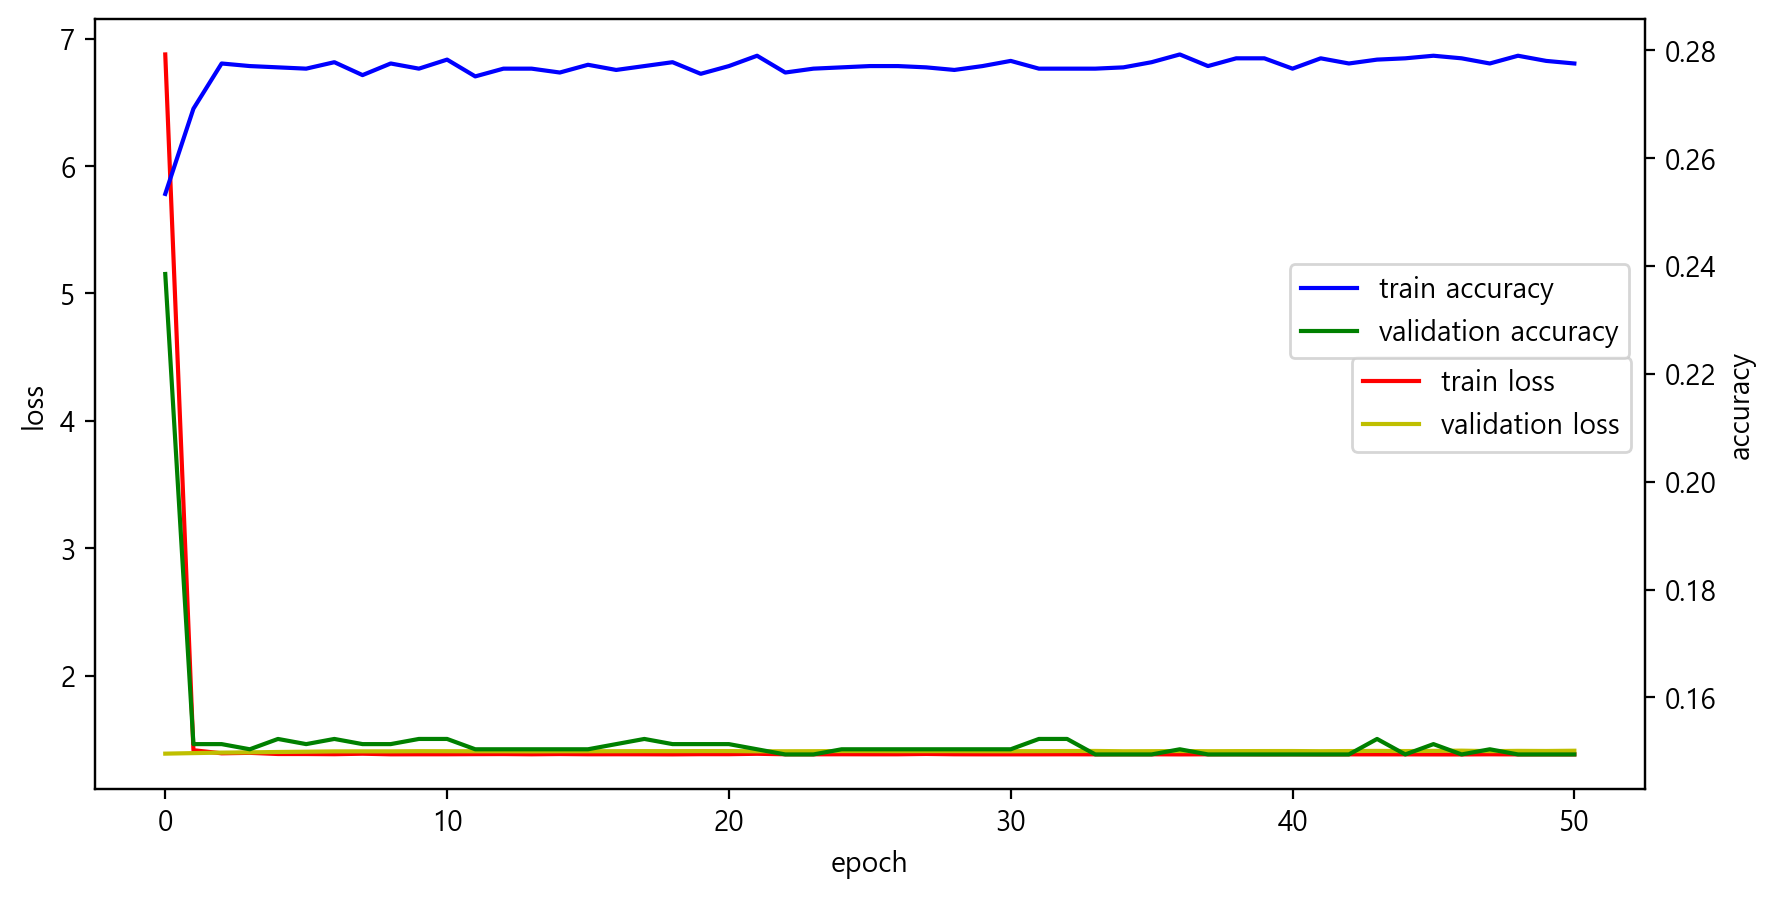

In [309]:
# 학습과정 표시하기
fig, loss_ax = plt.subplots(figsize=(10,5))
loss_ax.plot(hist.history['loss'], 'r', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'y', label='validation loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='validation accuracy')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='center right')
acc_ax.legend(bbox_to_anchor=(0.999, 0.7))
plt.show()

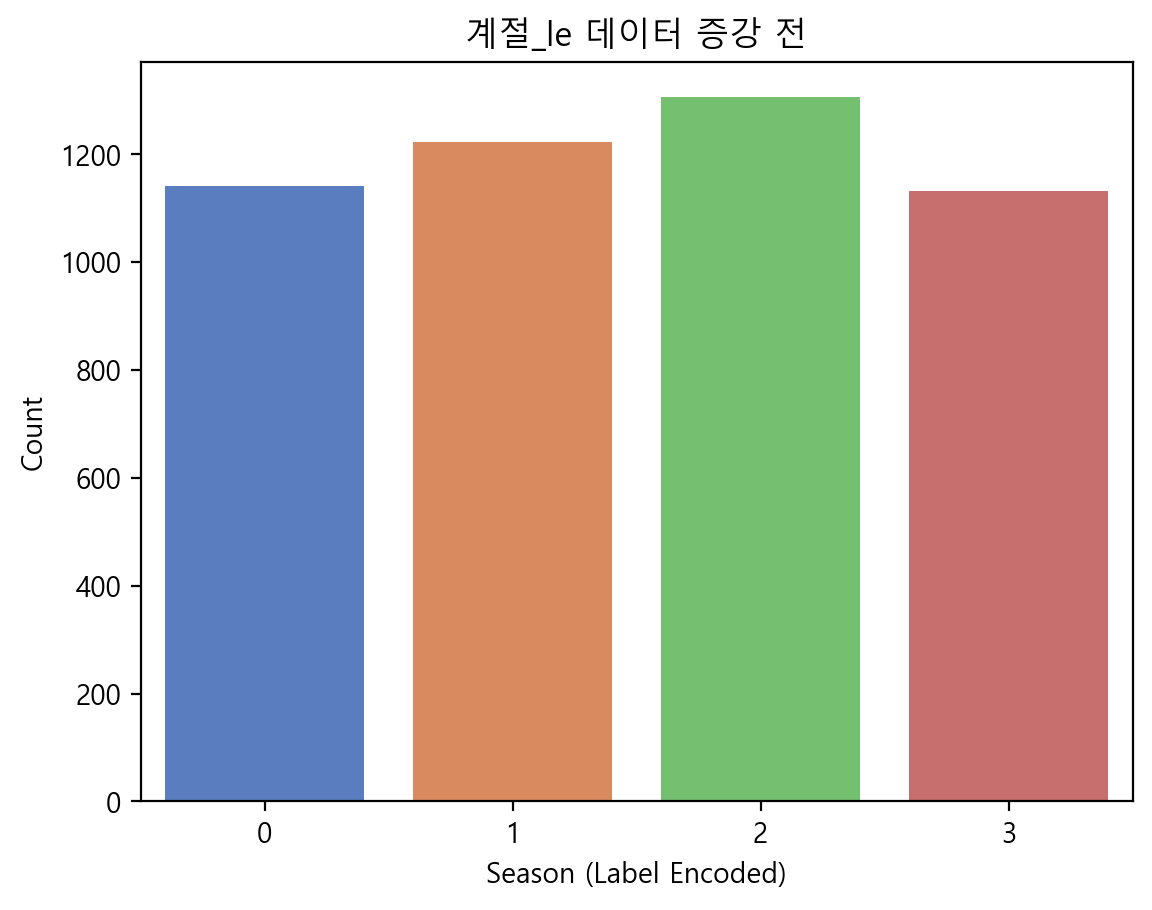

In [310]:
# 데이터 증강 전
sns.countplot(x=y_train, palette='muted')
plt.title('계절_le 데이터 증강 전')
plt.xlabel('Season (Label Encoded)')
plt.ylabel('Count')
plt.show()

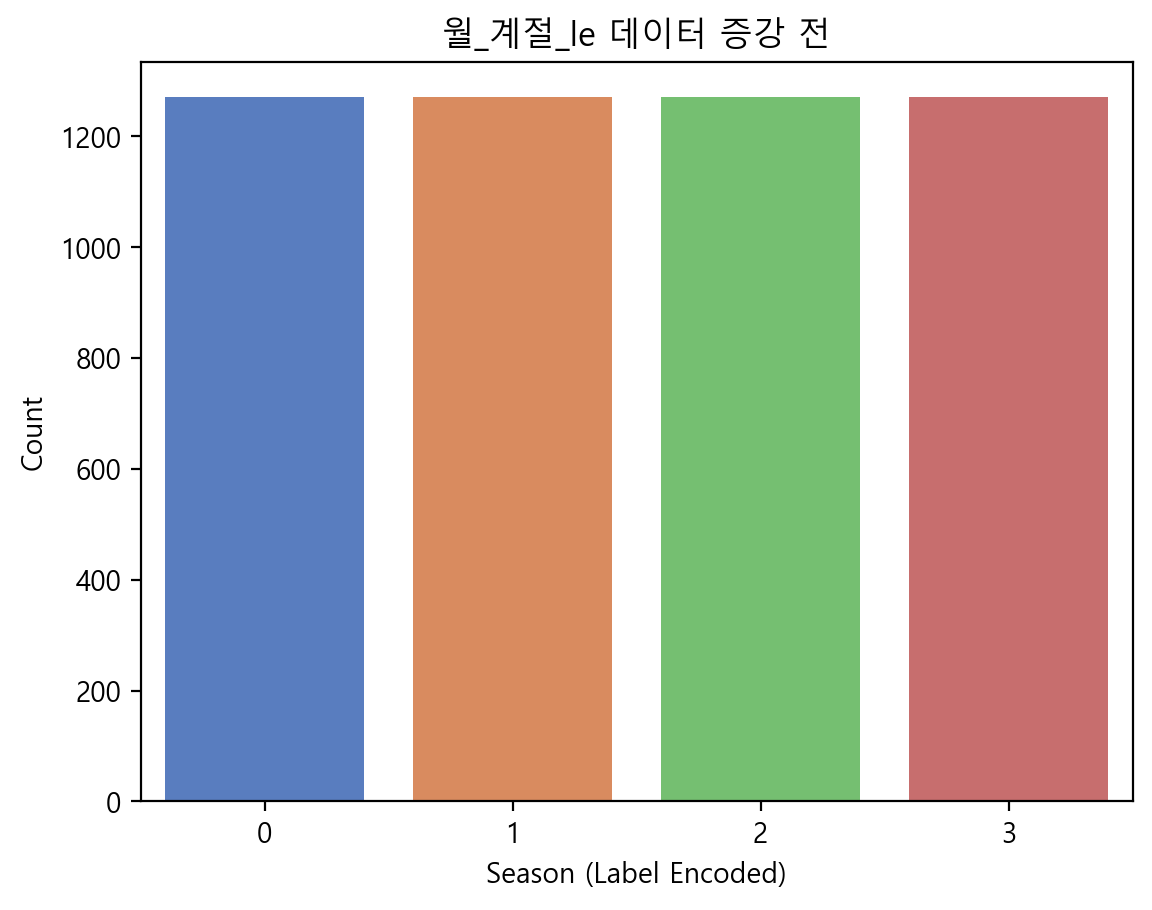

In [171]:
# 데이터 증강 후
sns.countplot(x=y_train_smote, palette='muted')
plt.title('월_계절_le 데이터 증강 전')
plt.xlabel('Season (Label Encoded)')
plt.ylabel('Count')
plt.show()

### 재시작시

In [356]:
# movies, movies_mean
# movies.to_csv('result/movies.csv', index=False, encoding='utf-8')
# movies_mean.to_csv('result/movies_mean.csv', index=False, encoding='utf-8')
# movie_df = pd.read_csv('result/movie_df.csv')
movies = pd.read_csv('result/movies.csv')
movies_mean = pd.read_csv('result/movies_mean.csv')
movies_mean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5999 entries, 0 to 5998
Data columns (total 18 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   영화제목     5999 non-null   object 
 1   유통회사명    5999 non-null   object 
 2   개봉년도     5999 non-null   int64  
 3   개봉월      5999 non-null   int64  
 4   총스크린수    5999 non-null   float64
 5   관람객수     5999 non-null   float64
 6   장르       5999 non-null   object 
 7   등급       5999 non-null   object 
 8   네이버_평점   5999 non-null   float64
 9   씨네21_평점  5999 non-null   float64
 10  평균평점     5999 non-null   float64
 11  장르2      5999 non-null   int64  
 12  등급_le    5999 non-null   int64  
 13  관람객수_le  5999 non-null   int64  
 14  계절_le    5999 non-null   int64  
 15  계절       5999 non-null   int64  
 16  관객수_등급   5999 non-null   int64  
 17  장르_le    5999 non-null   int64  
dtypes: float64(5), int64(9), object(4)
memory usage: 843.7+ KB
